# Preprocesamiento General del Dataset

---

## Trabajo Fin de M√°ster (TFM)
**M√°ster en Anal√≠tica de Datos en Marketing Digital**  
**T√≠tulo del TFM**: *An√°lisis predictivo del comportamiento del consumidor a trav√©s del an√°lisis de datos*

---

## Objetivo del notebook

El objetivo de este notebook es construir una **Tabla Maestra Limpia** a partir del dataset original `Full_Customer_Event_Data`, realizando los procesos de:

- **Limpieza b√°sica** de columnas y registros innecesarios o inconsistentes.
- **Tratamiento de outliers** mediante winsorizaci√≥n en variables num√©ricas.
- **Agrupaci√≥n de variables categ√≥ricas** para reducir cardinalidad y ruido.
- **Creaci√≥n de variables estables** (como `has_promo`) para posteriores an√°lisis.
- **Preparaci√≥n de un dataset base robusto** para su posterior uso en flujos de predicci√≥n y segmentaci√≥n.

---

## Enfoque

- **Las variables derivadas espec√≠ficas** (ratios, ticket medio, indicadores de promociones) **se crear√°n m√°s adelante en los datasets espec√≠ficos** (`dataset_prediccion` y `dataset_segmentacion`).
- **La codificaci√≥n** (One-Hot, Target Encoding) **se aplicar√° √∫nicamente tras crear los datasets espec√≠ficos**.
- Esta tabla maestra actuar√° como **base estable** para todo el proceso de an√°lisis y modelado posterior.

---

## 1: Preparacion inicial

En este primer paso realizamos:

- Importaci√≥n de librer√≠as necesarias,
- Configuraci√≥n de conexi√≥n a la base de datos PostgreSQL,
- Carga inicial del dataset `Full_Customer_Event_Data`.

Todo preparado para comenzar el preprocesamiento general.

---

In [1]:
import pandas as pd
from sqlalchemy import create_engine,text
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar variables de entorno
load_dotenv(override=True)

# Configuraci√≥n de conexi√≥n
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_PORT = os.getenv("DB_PORT")

# Crear el motor de conexi√≥n a PostgreSQL
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

## 2: Limpieza b√°sica de columnas

---

### Objetivo

Reducir el dataset `Full_Customer_Event_Data` a un conjunto de variables realmente relevantes para el an√°lisis, eliminando:

- Datos personales que no aportan valor anal√≠tico,
- Identificadores t√©cnicos que no son necesarios para trazabilidad,
- Variables redundantes o no discriminativas.

Todo esto respetando la trazabilidad m√≠nima necesaria (`customer_id`, `event_id`, `session_id`) para posteriores an√°lisis y auditor√≠as.

---

### Decisiones tomadas

| Decisi√≥n | Justificaci√≥n |
|:---------|:--------------|
| **Mantener identificadores anal√≠ticos** (`customer_id`, `event_id`, `session_id`) | Garantizan la trazabilidad entre eventos, sesiones y clientes sin introducir riesgos de privacidad. |
| **Eliminar datos personales** (`first_name`, `last_name`, `email`, `username`) | No aportan valor predictivo ni descriptivo, y suponen un riesgo innecesario para la privacidad. |
| **Eliminar identificadores t√©cnicos** (`device_id`, `device_version`) | Variables puramente t√©cnicas, de alta dispersi√≥n o sin procesamiento espec√≠fico, que no aportan valor anal√≠tico. |
| **Eliminar `home_country`** | El 97% de los registros pertenecen a Indonesia, por lo que no aporta valor discriminativo al an√°lisis. |
| **Conservar variables econ√≥micas, categ√≥ricas y geogr√°ficas relevantes** | Variables como `item_price`, `product_quantity`, `articletype`, `home_location_lat`, `home_location_long`, etc., son esenciales para el modelado, la segmentaci√≥n y el an√°lisis espacial. |

---

### Variables eliminadas en este paso

- `first_name`
- `last_name`
- `email`
- `username`
- `device_id`
- `device_version`
- `home_country`

---

### Tratamiento espec√≠fico de variables geogr√°ficas

| Variable | Decisi√≥n | Justificaci√≥n |
|:---------|:---------|:--------------|
| `home_location` | Mantener | Puede ser √∫til para segmentaciones regionales o visualizaciones |
| `home_location_lat`, `home_location_long` | Mantener | Permiten realizar clustering espacial y an√°lisis geogr√°fico |
| `shipment_location_lat`, `shipment_location_long` | Mantener | Opcional para an√°lisis de destinos de env√≠o |

---

### Resultado esperado

Se obtiene una **tabla f√≠sica** (`Cleaned_Base_Table`) que:

- Conserva todos los datos relevantes para el an√°lisis y la trazabilidad,
- Elimina cualquier variable que pueda comprometer la privacidad o introducir ruido t√©cnico,
- Optimiza el rendimiento y la claridad del dataset para el tratamiento de outliers, transformaci√≥n de variables y construcci√≥n de datasets anal√≠ticos posteriores.

---

> Con esta limpieza b√°sica se establece una base s√≥lida, √©tica y eficiente para todo el proceso de preprocesamiento, an√°lisis predictivo y segmentaci√≥n del TFM.

---


In [14]:
%%time
# 1. Consulta SQL para crear la tabla limpia
query_create_clean_base_table = """
DROP TABLE IF EXISTS Cleaned_Base_Table;

CREATE TABLE Cleaned_Base_Table AS
SELECT 
    customer_id,
    home_location_lat,
    home_location_long,
    home_location,
    first_join_date,
    event_id,
    session_id,
    event_name,
    event_time,
    traffic_source,
    device_type,
    customer_gender,
    birthdate,
    product_id,
    product_quantity,
    item_price,
    was_purchased,
    cem_promo_code,
    cem_promo_amount,
    search_keywords,
    cem_payment_status,
    booking_id,
    transaction_time,
    payment_method,
    transaction_payment_status,
    transaction_promo_code,
    transaction_promo_amount,
    shipment_fee,
    shipment_date_limit,
    shipment_location_lat,
    shipment_location_long,
    total_amount,
    gender,
    mastercategory,
    subcategory,
    articletype,
    basecolour,
    season,
    year,
    usage,
    productdisplayname,
    image_url
FROM Full_Customer_Event_Data;
"""

# 2. Ejecutar la creaci√≥n de la tabla limpia
with engine.begin() as conn:
    conn.execute(text(query_create_clean_base_table))

print("‚úÖ Tabla 'Cleaned_Base_Table' creada correctamente, eliminando datos personales, variables t√©cnicas y home_country.")

‚úÖ Tabla 'Cleaned_Base_Table' creada correctamente, eliminando datos personales, variables t√©cnicas y home_country.
CPU times: total: 15.6 ms
Wall time: 1min 4s


## 3: Tratamiento de outliers en variables num√©ricas

---

### Objetivo

Detectar y tratar valores at√≠picos (outliers) en las variables num√©ricas principales del dataset `Cleaned_Base_Table`,  
con el objetivo de:

- Reducir el impacto de valores extremos que puedan distorsionar el an√°lisis o el modelado,
- Mejorar la estabilidad y la interpretabilidad de las variables econ√≥micas y cuantitativas,
- Garantizar una base num√©rica robusta para la construcci√≥n de datasets anal√≠ticos posteriores.

---

### Metodolog√≠a

Se aplicar√° la **winsorizaci√≥n controlada** mediante el m√©todo del **rango intercuart√≠lico (IQR)**:

- Se calcular√°n el primer cuartil (Q1) y el tercer cuartil (Q3) para cada variable.
- Se determinar√° el rango intercuart√≠lico (IQR = Q3 - Q1).
- Se establecer√° un **l√≠mite superior** de winsorizaci√≥n:
  - **L√≠mite superior = Q3 + 1.5 √ó IQR**
- Los valores superiores al l√≠mite ser√°n reemplazados por el valor del l√≠mite.

> Nota: No se aplicar√° winsorizaci√≥n por debajo del l√≠mite inferior (Q1 - 1.5 √ó IQR), ya que las variables analizadas son precios, cantidades o importes que naturalmente no pueden ser negativos.

---

### Variables num√©ricas seleccionadas para tratamiento

| Variable | Descripci√≥n |
|:---------|:------------|
| `item_price` | Precio unitario del producto |
| `product_quantity` | N√∫mero de unidades compradas |
| `shipment_fee` | Coste de env√≠o |
| `transaction_promo_amount` | Importe del descuento promocional aplicado |
| `total_amount` | Importe total de la transacci√≥n |

---

### Resultado esperado

- Se generar√°n nuevas variables `*_winsorized` para cada variable tratada.
- Se preservar√° la variable original para trazabilidad y auditor√≠a.
- Se crear√° una base num√©rica robusta para la posterior construcci√≥n de:
  - `total_amount_final`
  - Nuevas variables derivadas espec√≠ficas para predicci√≥n o segmentaci√≥n.

---

> Este tratamiento garantiza un control riguroso de los outliers, mejorando la estabilidad anal√≠tica sin eliminar registros ni distorsionar la realidad econ√≥mica del dataset.

---


### 3.1 Winsorizaci√≥n de `item_price` y ajuste de `total_amount_winsorized`

---

#### Objetivo

Tratar los valores at√≠picos (outliers) en la variable `item_price`,  
y recalcular de manera coherente el importe total de la transacci√≥n (`total_amount_winsorized`),  
ajustando solo cuando se haya producido una compra (`was_purchased = TRUE`).

---

#### Procedimiento realizado

- **C√°lculo de Q1, Q3 e IQR** para `item_price` utilizando consultas SQL sobre la tabla `Cleaned_Base_Table`.
- **Determinaci√≥n del l√≠mite superior** de winsorizaci√≥n aplicando la f√≥rmula:  
  **L√≠mite = Q3 + 1.5 √ó IQR**.
- **Creaci√≥n de la nueva columna** `item_price_winsorized`:
  - Si `item_price` supera el l√≠mite, se reemplaza por el valor del l√≠mite.
  - Si no, se mantiene el valor original.
- **Creaci√≥n de la nueva columna** `total_amount_winsorized`:
  - Si `was_purchased = TRUE` y `item_price` supera el l√≠mite, se ajusta restando el exceso sobre la cantidad comprada.
  - En caso contrario, se conserva el `total_amount` original.

---

#### Resultado

- Se controlaron los valores extremos en `item_price`, preservando la estructura realista de precios.
- Se garantiz√≥ la coherencia del importe total (`total_amount_winsorized`) ajustando √∫nicamente en transacciones efectivamente realizadas.
- Las columnas originales (`item_price`, `total_amount`) se mantuvieron intactas para asegurar trazabilidad.

---

> Este enfoque modular y controlado permite limpiar los outliers sin perder integridad econ√≥mica, respetando el comportamiento real de los eventos de compra.

---


#### An√°lisis exploratorio previo de `item_price`

Antes de aplicar la winsorizaci√≥n, se realiz√≥ un an√°lisis exploratorio de la distribuci√≥n de `item_price`, con el objetivo de:

- Visualizar la concentraci√≥n de valores,
- Identificar la magnitud y cantidad de outliers,
- Confirmar la necesidad y justificaci√≥n del tratamiento.

Para ello, se utilizaron histogramas, boxplots y estad√≠sticas descriptivas.

---


In [15]:
%%time
# Paso 1: obtener Q1 y Q3 desde SQL
query_stats = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY item_price) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY item_price) AS q3
FROM Cleaned_Base_Table
WHERE item_price IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats, engine).iloc[0]

# Calcular umbral de outlier
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

# Paso 2: contar outliers y total
query_outliers = f"""
SELECT 
    COUNT(*) FILTER (WHERE item_price > {upper_threshold}) AS total_outliers,
    COUNT(*) AS total_values,
    ROUND(100.0 * COUNT(*) FILTER (WHERE item_price > {upper_threshold}) / COUNT(*), 2) AS porcentaje_outliers
FROM Cleaned_Base_Table
WHERE item_price IS NOT NULL;
"""
df_outliers = pd.read_sql_query(query_outliers, engine)
df_outliers

CPU times: total: 0 ns
Wall time: 7.2 s


total_outliers  total_values  porcentaje_outliers
0           36368       1937158                 1.88

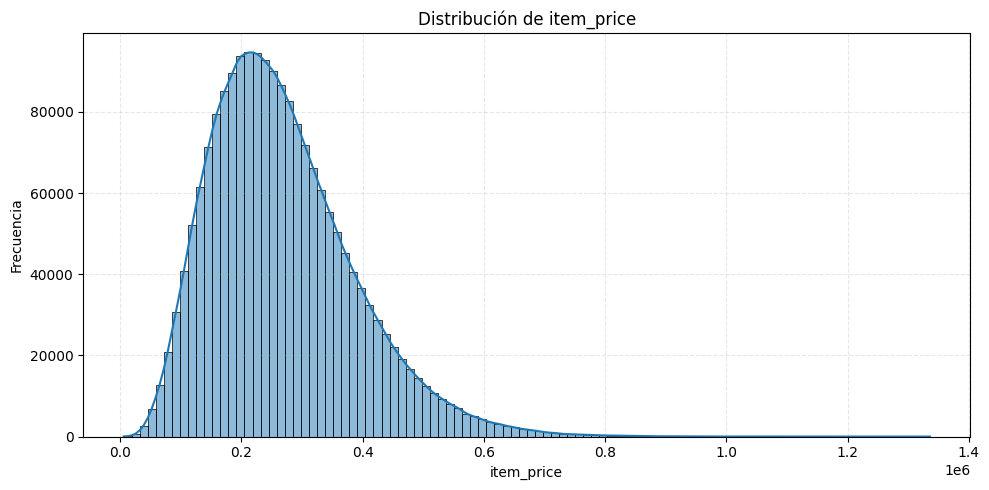

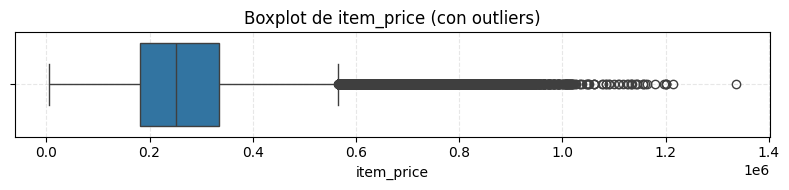

CPU times: total: 12.4 s
Wall time: 22 s


In [7]:
%%time
# Cargar solo la columna item_price desde la base de datos
query_item_price = """
SELECT item_price
FROM Cleaned_Base_Table
WHERE item_price IS NOT NULL;
"""

df_item_price = pd.read_sql_query(query_item_price, engine)
item_price_series = df_item_price['item_price']

# Histograma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(item_price_series, bins=100, kde=True)
plt.title("Distribuci√≥n de item_price")
plt.xlabel("item_price")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot para visualizar outliers
plt.figure(figsize=(8, 2))
sns.boxplot(x=item_price_series)
plt.title("Boxplot de item_price (con outliers)")
plt.xlabel("item_price")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### An√°lisis cuantitativo de outliers en `item_price`

El an√°lisis mostr√≥ que:

- Solo el 1,88% de los registros (36.368 casos) superaban el l√≠mite superior calculado mediante el m√©todo IQR.
- Aunque el porcentaje de outliers es relativamente bajo, la magnitud de los valores extremos justifica aplicar una winsorizaci√≥n superior para garantizar la estabilidad anal√≠tica.

Por tanto, se procede a crear la variable `item_price_winsorized`, limitando los valores extremos al umbral calculado.


In [15]:
%%time
# Paso 1: Obtener Q1 y Q3 desde Cleaned_Base_Table
query_stats = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY item_price) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY item_price) AS q3
FROM Cleaned_Base_Table
WHERE item_price IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats, engine).iloc[0]

# Paso 2: Calcular IQR y l√≠mite superior
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

print(f"item_price - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}, L√≠mite superior: {upper_threshold:.2f}")

# Paso 3: Crear columnas winsorizadas y actualizar en una sola consulta SQL
query_winsorize_item_price = f"""
-- A√±adir columnas si no existen
ALTER TABLE Cleaned_Base_Table
ADD COLUMN IF NOT EXISTS item_price_winsorized DOUBLE PRECISION,
ADD COLUMN IF NOT EXISTS total_amount_winsorized DOUBLE PRECISION;

-- A√±adir columnas si no existen
ALTER TABLE Cleaned_Base_Table
ADD COLUMN IF NOT EXISTS item_price_winsorized DOUBLE PRECISION,
ADD COLUMN IF NOT EXISTS total_amount_winsorized DOUBLE PRECISION;

-- Actualizar item_price_winsorized y total_amount_winsorized
UPDATE Cleaned_Base_Table
SET 
    item_price_winsorized = CASE
        WHEN item_price > {upper_threshold} THEN {upper_threshold}
        ELSE item_price
    END,
    
    total_amount_winsorized = CASE
        WHEN was_purchased = TRUE AND item_price > {upper_threshold}
        THEN total_amount - ((item_price - {upper_threshold}) * COALESCE(product_quantity, 1))
        ELSE total_amount
    END;
"""

# Ejecutar todo
with engine.begin() as conn:
    conn.execute(text(query_winsorize_item_price))

print("‚úÖ item_price_winsorized y total_amount_winsorized creados y actualizados correctamente.")


# 4. Verificar registros modificados
query_check_modificados = f"""
SELECT COUNT(*) AS registros_modificados
FROM Cleaned_Base_Table
WHERE item_price_winsorized <> item_price;
"""
modificados = pd.read_sql_query(query_check_modificados, engine).iloc[0, 0]
print(f"Registros modificados por winsorizaci√≥n: {modificados}")

# 4. Verificar registros modificados
query_check_modificados = f"""
SELECT COUNT(*) AS registros_modificados
FROM Cleaned_Base_Table
WHERE item_price_winsorized <> item_price;
"""
modificados = pd.read_sql_query(query_check_modificados, engine).iloc[0, 0]
print(f"Registros modificados por winsorizaci√≥n: {modificados}")

item_price - Q1: 181535.00, Q3: 335410.00, IQR: 153875.00, L√≠mite superior: 566222.50
‚úÖ item_price_winsorized y total_amount_winsorized creados y actualizados correctamente.
Registros modificados por winsorizaci√≥n: 36368
Registros modificados por winsorizaci√≥n: 36368
CPU times: total: 0 ns
Wall time: 2min 32s


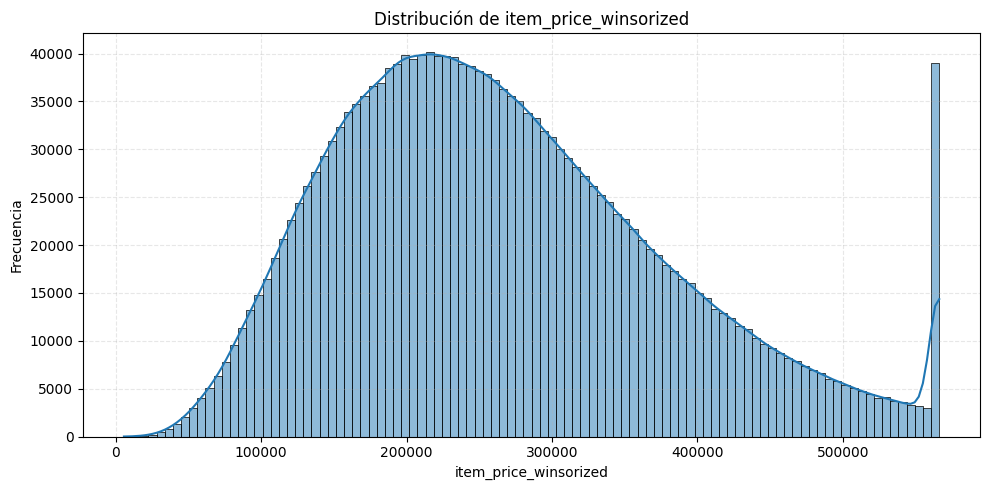

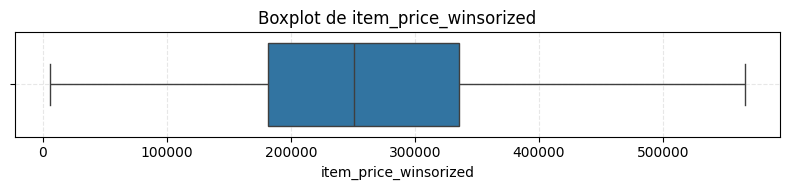

CPU times: total: 17.1 s
Wall time: 22.3 s


In [7]:
%%time
# Cargar solo la columna item_price desde la base de datos
query_item_price_winsorized = """
SELECT item_price_winsorized
FROM Cleaned_Base_Table
WHERE item_price_winsorized IS NOT NULL;
"""

df_item_price_winsorized = pd.read_sql_query(query_item_price_winsorized, engine)
item_price_winsorized_series = df_item_price_winsorized['item_price_winsorized']

# Histograma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(item_price_winsorized_series, bins=100, kde=True)
plt.title("Distribuci√≥n de item_price_winsorized")
plt.xlabel("item_price_winsorized")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot para visualizar outliers
plt.figure(figsize=(8, 2))
sns.boxplot(x=item_price_winsorized_series)
plt.title("Boxplot de item_price_winsorized")
plt.xlabel("item_price_winsorized")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 Winsorizaci√≥n de `shipment_fee` y ajuste de `total_amount_winsorized`

---

#### Objetivo

Tratar los valores at√≠picos (outliers) en la variable `shipment_fee`,  
y recalcular de manera coherente el importe total de la transacci√≥n (`total_amount_winsorized`)  
ajustando √∫nicamente cuando se detecten valores extremos.

---

#### Procedimiento realizado

- **C√°lculo de Q1, Q3 e IQR** para `shipment_fee` utilizando consultas SQL sobre la tabla `Cleaned_Base_Table`.
- **Determinaci√≥n del l√≠mite superior** de winsorizaci√≥n aplicando la f√≥rmula:  
  **L√≠mite = Q3 + 1.5 √ó IQR**.
- **Creaci√≥n de la nueva columna** `shipment_fee_winsorized`:
  - Si `shipment_fee` supera el l√≠mite, se reemplaza por el valor del l√≠mite.
  - Si no, se mantiene el valor original.
- **Ajuste de `total_amount_winsorized`**:
  - Si `shipment_fee` supera el l√≠mite, se recalcula sumando la diferencia al importe total ya ajustado.

---

#### Resultado

- Se controlaron los valores extremos en `shipment_fee`.
- Se garantiz√≥ la coherencia del importe total (`total_amount_winsorized`), reflejando correctamente el coste de env√≠o corregido.
- Se preservaron las columnas originales (`shipment_fee`) para trazabilidad.

---

> Este tratamiento modular de variables permite un control progresivo de los outliers en el dataset, asegurando estabilidad anal√≠tica sin sobrescribir datos originales.

---


In [8]:
%%time
# Paso 1: obtener Q1 y Q3 desde SQL
query_stats = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY shipment_fee) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY shipment_fee) AS q3
FROM Cleaned_Base_Table
WHERE shipment_fee IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats, engine).iloc[0]

# Calcular umbral de outlier
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

# Paso 2: contar outliers y total
query_outliers = f"""
SELECT 
    COUNT(*) FILTER (WHERE shipment_fee > {upper_threshold}) AS total_outliers,
    COUNT(*) AS total_values,
    ROUND(100.0 * COUNT(*) FILTER (WHERE shipment_fee > {upper_threshold}) / COUNT(*), 2) AS porcentaje_outliers
FROM Cleaned_Base_Table
WHERE shipment_fee IS NOT NULL;
"""
df_outliers = pd.read_sql_query(query_outliers, engine)
df_outliers

CPU times: total: 0 ns
Wall time: 8.31 s


total_outliers  total_values  porcentaje_outliers
0          404147      12463005                 3.24

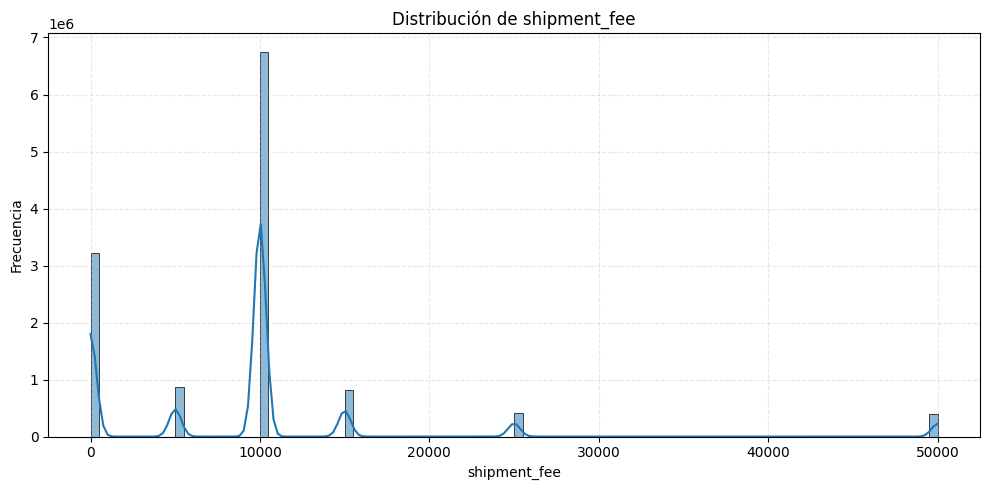

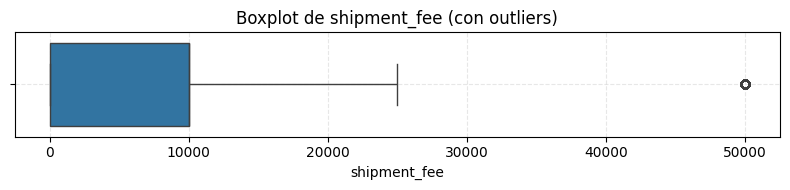

CPU times: total: 1min 18s
Wall time: 1min 23s


In [9]:
%%time
# Cargar solo la columna item_price desde la base de datos
query_shipment_fee = """
SELECT shipment_fee
FROM Cleaned_Base_Table
WHERE shipment_fee IS NOT NULL;
"""

df_shipment_fee = pd.read_sql_query(query_shipment_fee, engine)
shipment_fee_series = df_shipment_fee['shipment_fee']

# Histograma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(shipment_fee_series, bins=100, kde=True)
plt.title("Distribuci√≥n de shipment_fee")
plt.xlabel("shipment_fee")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot para visualizar outliers
plt.figure(figsize=(8, 2))
sns.boxplot(x=shipment_fee_series)
plt.title("Boxplot de shipment_fee (con outliers)")
plt.xlabel("shipment_fee")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### An√°lisis cuantitativo de outliers en `shipment_fee`

El an√°lisis mostr√≥ que:

- El 3,24% de los registros (404.147 casos) superaban el l√≠mite superior calculado mediante el m√©todo IQR.
- Dado el volumen absoluto de outliers y su impacto potencial sobre estad√≠sticas y modelos, se consider√≥ necesaria la aplicaci√≥n de winsorizaci√≥n en `shipment_fee`.

Por tanto, se proceder√° a crear la variable `shipment_fee_winsorized`, limitando los valores superiores al umbral calculado.

El importe total de la transacci√≥n (`total_amount_winsorized`) ser√° tambi√©n ajustado para reflejar correctamente la correcci√≥n aplicada en los costes de env√≠o.

---


In [16]:
%%time
# Paso 1: Calcular Q1 y Q3 desde Cleaned_Base_Table
query_stats_shipment_fee = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY shipment_fee) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY shipment_fee) AS q3
FROM Cleaned_Base_Table
WHERE shipment_fee IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats_shipment_fee, engine).iloc[0]

# Paso 2: Calcular IQR y l√≠mite superior
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

print(f"shipment_fee - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}, L√≠mite superior: {upper_threshold:.2f}")

# Paso 3: Crear columnas y actualizar en una sola consulta SQL
query_winsorize_shipment_fee = f"""
-- A√±adir columna shipment_fee_winsorized si no existe
ALTER TABLE Cleaned_Base_Table
ADD COLUMN IF NOT EXISTS shipment_fee_winsorized DOUBLE PRECISION;

-- Actualizar shipment_fee_winsorized y ajustar total_amount_winsorized
UPDATE Cleaned_Base_Table
SET 
    shipment_fee_winsorized = CASE
        WHEN shipment_fee > {upper_threshold} THEN {upper_threshold}
        ELSE shipment_fee
    END,
    
    total_amount_winsorized = CASE
        WHEN was_purchased = TRUE AND shipment_fee > {upper_threshold}
        THEN total_amount_winsorized - shipment_fee + {upper_threshold}
        ELSE total_amount_winsorized
    END;
"""

# Ejecutar la actualizaci√≥n
with engine.begin() as conn:
    conn.execute(text(query_winsorize_shipment_fee))

print("‚úÖ shipment_fee_winsorized creado y total_amount_winsorized ajustado correctamente.")

# 4. Verificar registros modificados
query_check_modificados = f"""
SELECT COUNT(*) AS registros_modificados
FROM Cleaned_Base_Table
WHERE shipment_fee_winsorized <> shipment_fee;
"""
modificados = pd.read_sql_query(query_check_modificados, engine).iloc[0, 0]
print(f"Registros modificados por winsorizaci√≥n: {modificados}")

shipment_fee - Q1: 0.00, Q3: 10000.00, IQR: 10000.00, L√≠mite superior: 25000.00
‚úÖ shipment_fee_winsorized creado y total_amount_winsorized ajustado correctamente.
Registros modificados por winsorizaci√≥n: 404147
CPU times: total: 15.6 ms
Wall time: 2min 47s


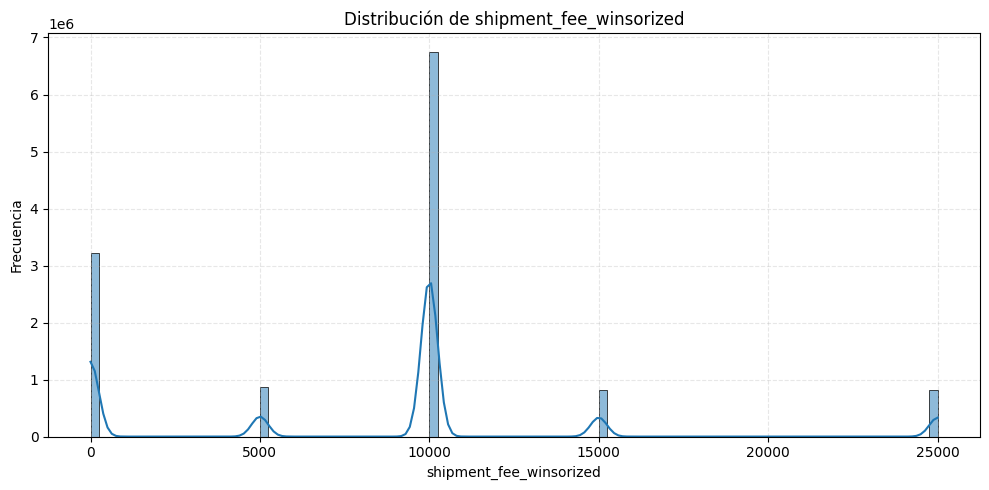

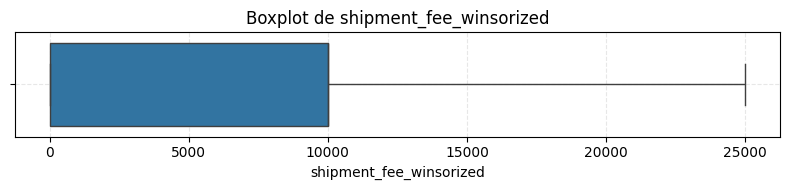

CPU times: total: 1min 35s
Wall time: 1min 51s


In [11]:
%%time
# Cargar solo la columna item_price desde la base de datos
query_shipment_fee_winsorized = """
SELECT shipment_fee_winsorized
FROM Cleaned_Base_Table
WHERE shipment_fee_winsorized IS NOT NULL;
"""

df_shipment_fee_winsorized = pd.read_sql_query(query_shipment_fee_winsorized, engine)
shipment_fee_winsorized_series = df_shipment_fee_winsorized['shipment_fee_winsorized']

# Histograma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(shipment_fee_winsorized_series, bins=100, kde=True)
plt.title("Distribuci√≥n de shipment_fee_winsorized")
plt.xlabel("shipment_fee_winsorized")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot para visualizar outliers
plt.figure(figsize=(8, 2))
sns.boxplot(x=shipment_fee_winsorized_series)
plt.title("Boxplot de shipment_fee_winsorized")
plt.xlabel("shipment_fee_winsorized")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 Winsorizaci√≥n de `product_quantity` y ajuste de `total_amount_winsorized`

---

#### Objetivo

Tratar los valores at√≠picos (outliers) en la variable `product_quantity`,  
que representa la cantidad de unidades compradas por evento.

Dado que valores anormalmente altos podr√≠an distorsionar el an√°lisis de importes y comportamientos de compra,  
se aplicar√° winsorizaci√≥n controlada para estabilizar esta variable.

---

#### Procedimiento

- Calcular Q1, Q3, IQR y definir l√≠mite superior para winsorizaci√≥n.
- Contar y visualizar outliers.
- Crear nueva columna `product_quantity_winsorized`.
- Recalcular `total_amount_winsorized` ajustando la cantidad al nuevo valor corregido.

---

#### Resultado esperado

- Control de cantidades anormalmente elevadas.
- Preservaci√≥n de la l√≥gica econ√≥mica de la transacci√≥n tras el ajuste.

---


In [12]:
%%time
# Calcular Q1 y Q3 para product_quantity
query_stats_product_quantity = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY product_quantity) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY product_quantity) AS q3
FROM Cleaned_Base_Table
WHERE product_quantity IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats_product_quantity, engine).iloc[0]

# Calcular IQR y l√≠mite superior
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr
print(f"product_quantity - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}, L√≠mite superior: {upper_threshold:.2f}")

# Contar n√∫mero de outliers
query_outliers_product_quantity = f"""
SELECT 
    COUNT(*) FILTER (WHERE product_quantity > {upper_threshold}) AS total_outliers,
    COUNT(*) AS total_values,
    ROUND(100.0 * COUNT(*) FILTER (WHERE product_quantity > {upper_threshold}) / COUNT(*), 2) AS porcentaje_outliers
FROM Cleaned_Base_Table
WHERE product_quantity IS NOT NULL;
"""
df_outliers_product_quantity = pd.read_sql_query(query_outliers_product_quantity, engine)
df_outliers_product_quantity

product_quantity - Q1: 1.00, Q3: 1.00, IQR: 0.00, L√≠mite superior: 1.00
CPU times: total: 31.2 ms
Wall time: 24.9 s


total_outliers  total_values  porcentaje_outliers
0          322207       1937158                16.63

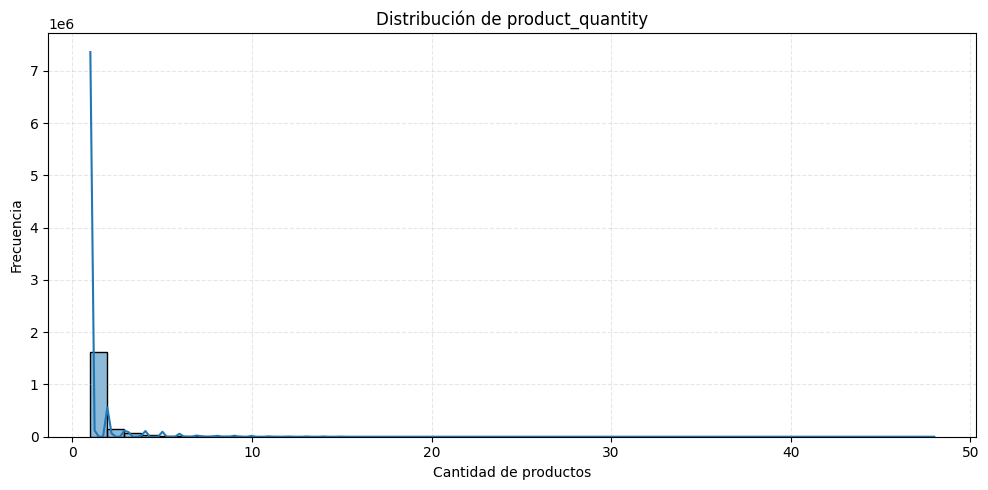

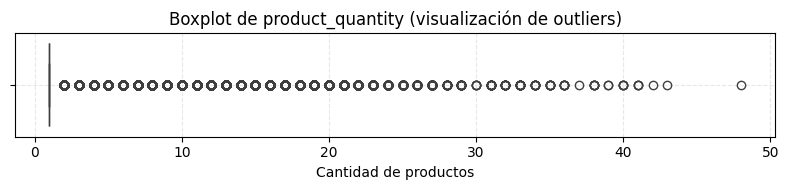

CPU times: total: 7.14 s
Wall time: 22.3 s


In [13]:
%%time
# Cargar datos de product_quantity
query_product_quantity = """
SELECT product_quantity
FROM Cleaned_Base_Table
WHERE product_quantity IS NOT NULL;
"""
df_product_quantity = pd.read_sql_query(query_product_quantity, engine)
product_quantity_series = df_product_quantity['product_quantity']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(product_quantity_series, bins=50, kde=True)
plt.title('Distribuci√≥n de product_quantity')
plt.xlabel('Cantidad de productos')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=product_quantity_series)
plt.title('Boxplot de product_quantity (visualizaci√≥n de outliers)')
plt.xlabel('Cantidad de productos')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


#### An√°lisis exploratorio de outliers en `product_quantity`

---

##### Resultados del an√°lisis inicial

- Q1: 1.00
- Q3: 1.00
- IQR: 0.00
- L√≠mite superior por IQR: 1.00
- Total de registros: 1.937.158
- Total de registros considerados outliers (> 1 unidad): 322.207
- Porcentaje de outliers: 16,63%

---

##### Interpretaci√≥n

- El m√©todo cl√°sico de detecci√≥n de outliers por IQR detecta como at√≠picos **todos los eventos con m√°s de una unidad comprada**.
- Sin embargo, en un entorno de retail, **comprar 2, 3 o m√°s unidades** es un comportamiento completamente normal en ciertos productos y campa√±as.
- Por tanto, **aplicar winsorizaci√≥n autom√°tica con l√≠mite = 1.00** ser√≠a excesivamente restrictivo y eliminar√≠a informaci√≥n comercial v√°lida.

---

##### Decisi√≥n

Se concluye que:

- El m√©todo de IQR cl√°sico **no es adecuado** para `product_quantity`.
- Se propone calcular **percentiles superiores** (P80, P85, P90, P95) para definir un **nuevo umbral m√°s razonable** de winsorizaci√≥n.
- El objetivo es identificar y tratar √∫nicamente **casos realmente extremos** (compras masivas de decenas de unidades),  
sin afectar compras normales de baja cantidad.

---

> Esta decisi√≥n asegura un control m√°s realista de los outliers, adaptado a la naturaleza discreta y comercial de la variable `product_quantity`.

---


In [14]:
%%time
# Consulta SQL para calcular percentiles superiores
query_percentiles_product_quantity = """
SELECT 
    PERCENTILE_CONT(0.80) WITHIN GROUP (ORDER BY product_quantity) AS p80,
    PERCENTILE_CONT(0.85) WITHIN GROUP (ORDER BY product_quantity) AS p85,
    PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY product_quantity) AS p90,
    PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY product_quantity) AS p95
FROM Cleaned_Base_Table
WHERE product_quantity IS NOT NULL;
"""

# Ejecutar consulta y capturar resultados
percentiles_product_quantity = pd.read_sql_query(query_percentiles_product_quantity, engine)

# Mostrar resultados
percentiles_product_quantity


CPU times: total: 0 ns
Wall time: 16 s


p80  p85  p90  p95
0  1.0  2.0  2.0  4.0

#### An√°lisis de percentiles superiores en `product_quantity`

Se calcularon los percentiles P80, P85, P90 y P95 para `product_quantity`:

| Percentil | Valor |
|:----------|:------|
| P80 | 1 unidad |
| P85 | 2 unidades |
| P90 | 2 unidades |
| P95 | 4 unidades |

El an√°lisis mostr√≥ que el 95% de las compras corresponden a eventos de 4 unidades o menos.

---

#### Decisi√≥n de tratamiento

Se decidi√≥ **winsorizar `product_quantity` por encima de 4 unidades**,  
reemplazando cualquier valor mayor a 4 por 4.

Esta estrategia permite:

- Preservar compras normales de baja cantidad,
- Controlar casos extremos que podr√≠an distorsionar el an√°lisis de importes y comportamiento de compra.

---


In [17]:
%%time
# Definir manualmente el umbral basado en el P95 que calculamos
upper_threshold_product_quantity = 4  # Sabemos que P95 = 4

# Crear y actualizar columnas
query_winsorize_product_quantity = f"""
-- A√±adir columna product_quantity_winsorized si no existe
ALTER TABLE Cleaned_Base_Table
ADD COLUMN IF NOT EXISTS product_quantity_winsorized INTEGER;

-- Actualizar product_quantity_winsorized
UPDATE Cleaned_Base_Table
SET product_quantity_winsorized = CASE
    WHEN product_quantity > {upper_threshold_product_quantity} THEN {upper_threshold_product_quantity}
    ELSE product_quantity
END;

-- Ajustar total_amount_winsorized
UPDATE Cleaned_Base_Table
SET total_amount_winsorized = CASE
    WHEN was_purchased = TRUE AND product_quantity > {upper_threshold_product_quantity}
    THEN total_amount_winsorized 
        - ((product_quantity - product_quantity_winsorized) * item_price_winsorized)
    ELSE total_amount_winsorized
END;
"""

# Ejecutar todo
with engine.begin() as conn:
    conn.execute(text(query_winsorize_product_quantity))

print("‚úÖ product_quantity_winsorized creado y total_amount_winsorized ajustado correctamente.")

# 4. Verificar registros modificados
query_check_modificados = f"""
SELECT COUNT(*) AS registros_modificados
FROM Cleaned_Base_Table
WHERE product_quantity_winsorized <> product_quantity;
"""
modificados = pd.read_sql_query(query_check_modificados, engine).iloc[0, 0]
print(f"Registros modificados por winsorizaci√≥n: {modificados}")

‚úÖ product_quantity_winsorized creado y total_amount_winsorized ajustado correctamente.
Registros modificados por winsorizaci√≥n: 70455
CPU times: total: 0 ns
Wall time: 6min 12s


#### Winsorizaci√≥n de `product_quantity` y ajuste optimizado de `total_amount_winsorized`

Se aplic√≥ la winsorizaci√≥n superior a `product_quantity`,  
limitando los valores m√°ximos a 4 unidades.

Para mantener la coherencia econ√≥mica:

- Se ajust√≥ `total_amount_winsorized` **√∫nicamente restando el exceso de unidades** multiplicado por el `item_price_winsorized`.
- No se recalcularon ni los descuentos promocionales ni los costes de env√≠o ya corregidos previamente.

Esta t√©cnica garantiza:

- La trazabilidad de los cambios,
- La m√≠nima alteraci√≥n necesaria en los registros,
- La preservaci√≥n precisa del comportamiento econ√≥mico de las transacciones.

Adem√°s, se verific√≥ el n√∫mero de registros afectados, asegurando el control del impacto de la transformaci√≥n.

---


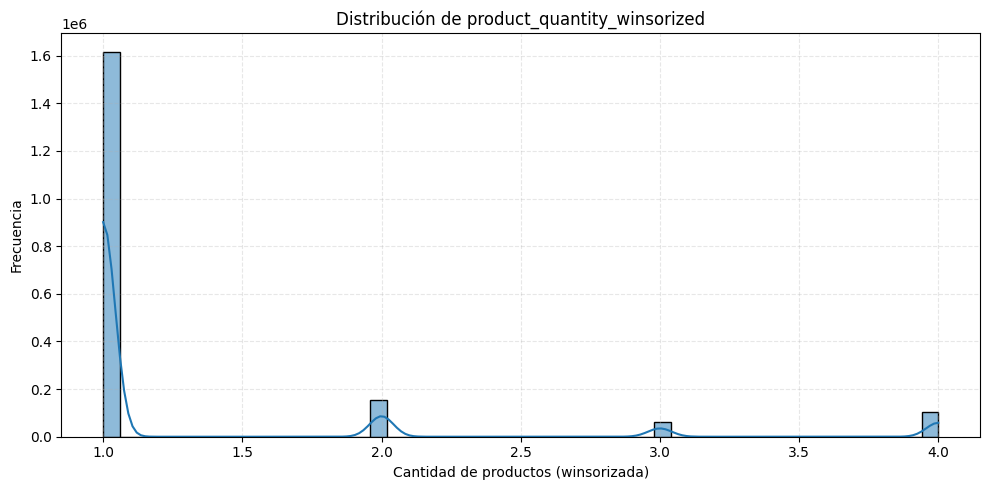

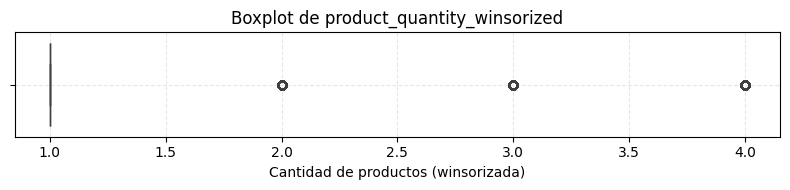

CPU times: total: 14.4 s
Wall time: 44.4 s


In [16]:
%%time
# Cargar los valores winsorizados de product_quantity
query_product_quantity_winsorized = """
SELECT product_quantity_winsorized
FROM Cleaned_Base_Table
WHERE product_quantity_winsorized IS NOT NULL;
"""

df_product_quantity_winsorized = pd.read_sql_query(query_product_quantity_winsorized, engine)
product_quantity_winsorized_series = df_product_quantity_winsorized['product_quantity_winsorized']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(product_quantity_winsorized_series, bins=50, kde=True)
plt.title('Distribuci√≥n de product_quantity_winsorized')
plt.xlabel('Cantidad de productos (winsorizada)')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=product_quantity_winsorized_series)
plt.title('Boxplot de product_quantity_winsorized')
plt.xlabel('Cantidad de productos (winsorizada)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### 3.4 Winsorizaci√≥n de `transaction_promo_amount` y ajuste de `total_amount_winsorized`

---

#### Objetivo

Tratar los valores at√≠picos en `transaction_promo_amount`,  
controlando descuentos anormalmente elevados que podr√≠an distorsionar el importe total de las transacciones.

---

#### Procedimiento

- Calcular Q1, Q3, IQR y l√≠mite superior de winsorizaci√≥n.
- Contar y visualizar los outliers.
- Crear nueva columna `transaction_promo_amount_winsorized`.
- Recalcular `total_amount_winsorized` corrigiendo el importe de descuento excesivo.

---

#### Resultado esperado

- Control de descuentos extremos,
- Coherencia econ√≥mica en los importes de transacciones,
- Preservaci√≥n de la trazabilidad original.

---


In [17]:
%%time
# Paso 1: Calcular Q1 y Q3 desde Cleaned_Base_Table
query_stats_transaction_promo_amount = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY transaction_promo_amount) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY transaction_promo_amount) AS q3
FROM Cleaned_Base_Table
WHERE transaction_promo_amount IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats_transaction_promo_amount, engine).iloc[0]

# Calcular IQR y l√≠mite superior
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

print(f"transaction_promo_amount - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}, L√≠mite superior: {upper_threshold:.2f}")

# Paso 2: Contar n√∫mero de outliers
query_outliers_transaction_promo_amount = f"""
SELECT 
    COUNT(*) FILTER (WHERE transaction_promo_amount > {upper_threshold}) AS total_outliers,
    COUNT(*) AS total_values,
    ROUND(100.0 * COUNT(*) FILTER (WHERE transaction_promo_amount > {upper_threshold}) / COUNT(*), 2) AS porcentaje_outliers
FROM Cleaned_Base_Table
WHERE transaction_promo_amount IS NOT NULL;
"""
df_outliers_transaction_promo_amount = pd.read_sql_query(query_outliers_transaction_promo_amount, engine)
df_outliers_transaction_promo_amount



transaction_promo_amount - Q1: 0.00, Q3: 4418.00, IQR: 4418.00, L√≠mite superior: 11045.00
CPU times: total: 15.6 ms
Wall time: 51.8 s


total_outliers  total_values  porcentaje_outliers
0          198835      12463005                  1.6

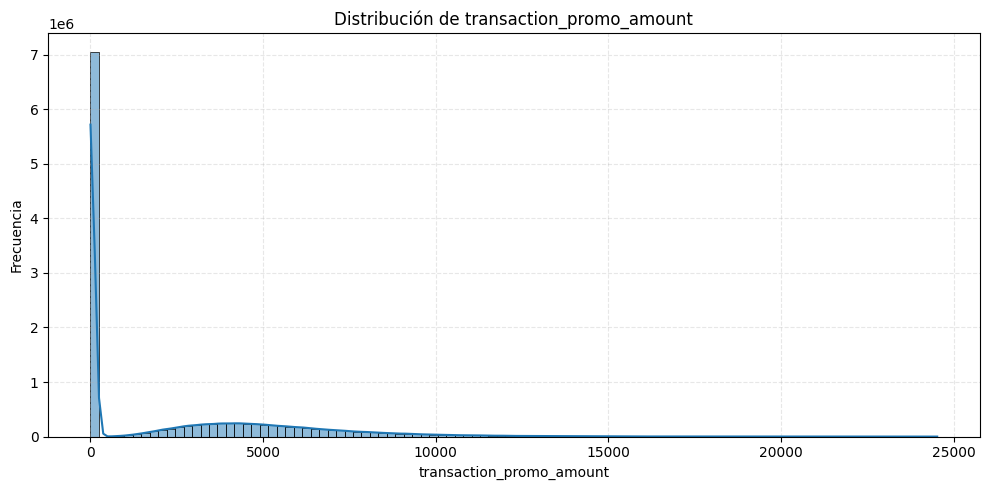

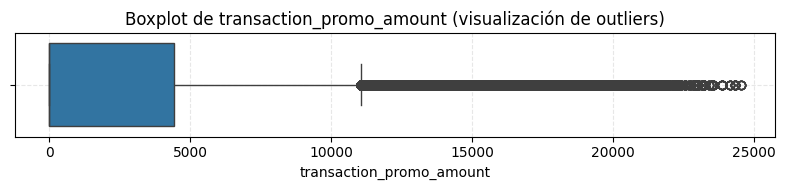

CPU times: total: 1min 6s
Wall time: 1min 33s


In [18]:
%%time
# Cargar solo los valores de transaction_promo_amount no nulos
query_transaction_promo_amount = """
SELECT transaction_promo_amount
FROM Cleaned_Base_Table
WHERE transaction_promo_amount IS NOT NULL;
"""
df_transaction_promo_amount = pd.read_sql_query(query_transaction_promo_amount, engine)
transaction_promo_amount_series = df_transaction_promo_amount['transaction_promo_amount']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(transaction_promo_amount_series, bins=100, kde=True)
plt.title('Distribuci√≥n de transaction_promo_amount')
plt.xlabel('transaction_promo_amount')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=transaction_promo_amount_series)
plt.title('Boxplot de transaction_promo_amount (visualizaci√≥n de outliers)')
plt.xlabel('transaction_promo_amount')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### An√°lisis cuantitativo de outliers en `transaction_promo_amount`

El an√°lisis mostr√≥ que:

- El 1,6% de los registros (198.835 casos) superaban el l√≠mite superior calculado mediante el m√©todo IQR.
- Aunque el porcentaje es relativamente bajo, el volumen absoluto de outliers es significativo en un dataset de m√°s de 12 millones de registros.
- Adem√°s, los valores an√≥malamente altos de descuento pueden distorsionar el importe total de las transacciones.

Por tanto, se confirm√≥ la necesidad de aplicar winsorizaci√≥n superior sobre `transaction_promo_amount`.

---


In [18]:
%%time
# Asumimos que tienes ya calculado el upper_threshold de transaction_promo_amount
# (si no, puedes volver a calcularlo, pero lo has hecho justo antes)

# Crear y actualizar columnas
query_winsorize_transaction_promo_amount = f"""
-- A√±adir columna transaction_promo_amount_winsorized si no existe
ALTER TABLE Cleaned_Base_Table
ADD COLUMN IF NOT EXISTS transaction_promo_amount_winsorized DOUBLE PRECISION;

-- Actualizar transaction_promo_amount_winsorized
UPDATE Cleaned_Base_Table
SET transaction_promo_amount_winsorized = CASE
    WHEN transaction_promo_amount > {upper_threshold} THEN {upper_threshold}
    ELSE transaction_promo_amount
END;

-- Ajustar total_amount_winsorized
UPDATE Cleaned_Base_Table
SET total_amount_winsorized = CASE
    WHEN was_purchased = TRUE AND transaction_promo_amount > {upper_threshold}
    THEN total_amount_winsorized 
         + (transaction_promo_amount - {upper_threshold})
    ELSE total_amount_winsorized
END;
"""

# Ejecutar en la base de datos
with engine.begin() as conn:
    conn.execute(text(query_winsorize_transaction_promo_amount))

print("‚úÖ transaction_promo_amount_winsorized creado y total_amount_winsorized ajustado correctamente.")

# 4. Verificar registros modificados
query_check_modificados = f"""
SELECT COUNT(*) AS registros_modificados
FROM Cleaned_Base_Table
WHERE transaction_promo_amount_winsorized <> transaction_promo_amount;
"""
modificados = pd.read_sql_query(query_check_modificados, engine).iloc[0, 0]
print(f"Registros modificados por winsorizaci√≥n: {modificados}")

‚úÖ transaction_promo_amount_winsorized creado y total_amount_winsorized ajustado correctamente.
Registros modificados por winsorizaci√≥n: 0
CPU times: total: 15.6 ms
Wall time: 6min 42s


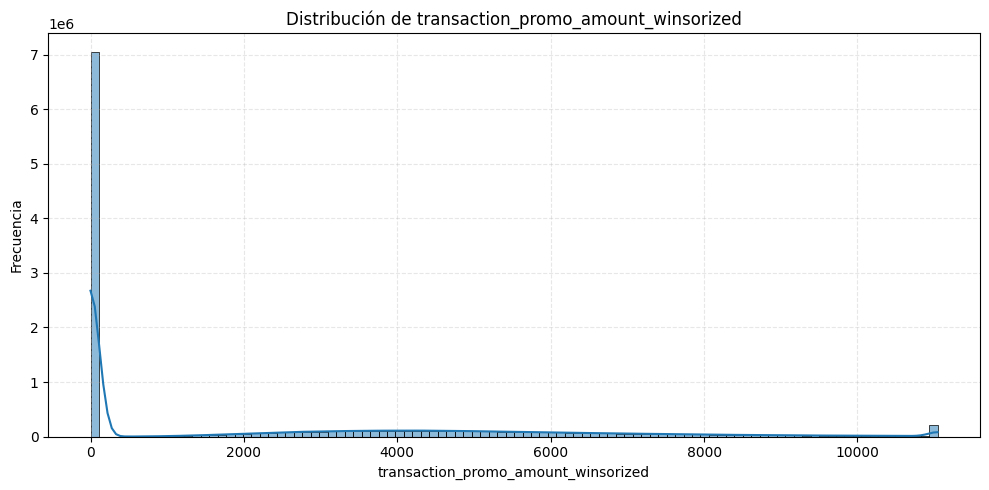

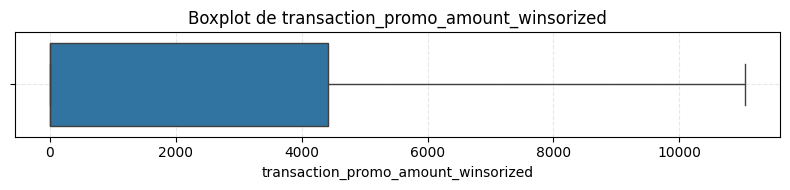

CPU times: total: 1min 28s
Wall time: 2min 14s


In [20]:
%%time
# Cargar los valores winsorizados de transaction_promo_amount
query_transaction_promo_amount_winsorized = """
SELECT transaction_promo_amount_winsorized
FROM Cleaned_Base_Table
WHERE transaction_promo_amount_winsorized IS NOT NULL;
"""
df_transaction_promo_amount_winsorized = pd.read_sql_query(query_transaction_promo_amount_winsorized, engine)
transaction_promo_amount_winsorized_series = df_transaction_promo_amount_winsorized['transaction_promo_amount_winsorized']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(transaction_promo_amount_winsorized_series, bins=100, kde=True)
plt.title('Distribuci√≥n de transaction_promo_amount_winsorized')
plt.xlabel('transaction_promo_amount_winsorized')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=transaction_promo_amount_winsorized_series)
plt.title('Boxplot de transaction_promo_amount_winsorized')
plt.xlabel('transaction_promo_amount_winsorized')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.5 Winsorizaci√≥n final de `total_amount_winsorized` (creaci√≥n de `total_amount_final`)

---

### Objetivo

El an√°lisis de la variable `total_amount_winsorized`, que representa el importe total corregido de cada transacci√≥n tras el tratamiento de outliers en variables econ√≥micas clave, tiene como finalidad:

- Evaluar la distribuci√≥n general del valor total de las transacciones.
- Identificar posibles valores at√≠picos residuales que puedan distorsionar el an√°lisis econ√≥mico o el modelado predictivo.
- Decidir si es necesaria una √∫ltima fase de winsorizaci√≥n o transformaci√≥n sobre el importe total.

---

### Metodolog√≠a

- Se calcular√°n estad√≠sticas descriptivas b√°sicas:
  - Media, mediana, cuartiles (Q1 y Q3), desviaci√≥n est√°ndar, m√≠nimo y m√°ximo.
- Se aplicar√° la regla del **rango intercuart√≠lico (IQR)** para detectar valores at√≠picos:
  - L√≠mite superior = `Q3 + 1.5 √ó IQR`
- Se calcular√°n tambi√©n percentiles altos (`P80`, `P85`, `P90`, `P95`) para evaluar diferentes umbrales de winsorizaci√≥n.
- Se visualizar√° la distribuci√≥n mediante:
  - Histograma,
  - Boxplot,
  - Y comparativa con winsorizaciones simuladas.

---

### Resultados esperados

- Determinar si `total_amount_winsorized` requiere una √∫ltima winsorizaci√≥n o puede conservarse tal como est√°.
- Estabilizar completamente la variable econ√≥mica m√°s cr√≠tica para su uso en:
  - Modelado de comportamiento de compra,
  - Segmentaciones por ticket medio,
  - An√°lisis de rentabilidad y sensibilidad.

---


In [37]:
%%time
# Paso 1: Calcular Q1 y Q3 para total_amount_winsorized
query_stats_total_amount_winsorized = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY total_amount_winsorized) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY total_amount_winsorized) AS q3
FROM Cleaned_Base_Table
WHERE total_amount_winsorized IS NOT NULL;
"""
q1, q3 = pd.read_sql_query(query_stats_total_amount_winsorized, engine).iloc[0]

# Calcular IQR y l√≠mite superior
iqr = q3 - q1
upper_threshold = q3 + 1.5 * iqr

print(f"total_amount_winsorized - Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}, L√≠mite superior: {upper_threshold:.2f}")

# Paso 2: Contar n√∫mero de outliers
query_outliers_total_amount_winsorized = f"""
SELECT 
    COUNT(*) FILTER (WHERE total_amount_winsorized > {upper_threshold}) AS total_outliers,
    COUNT(*) AS total_values,
    ROUND(100.0 * COUNT(*) FILTER (WHERE total_amount_winsorized > {upper_threshold}) / COUNT(*), 2) AS porcentaje_outliers
FROM Cleaned_Base_Table
WHERE total_amount_winsorized IS NOT NULL;
"""
df_outliers_total_amount_winsorized = pd.read_sql_query(query_outliers_total_amount_winsorized, engine)
df_outliers_total_amount_winsorized


üìä total_amount_winsorized - Q1: 207100.00, Q3: 567568.00, IQR: 360468.00, L√≠mite superior: 1108270.00
CPU times: total: 15.6 ms
Wall time: 1min 26s


total_outliers  total_values  porcentaje_outliers
0         1563234      12463005                12.54

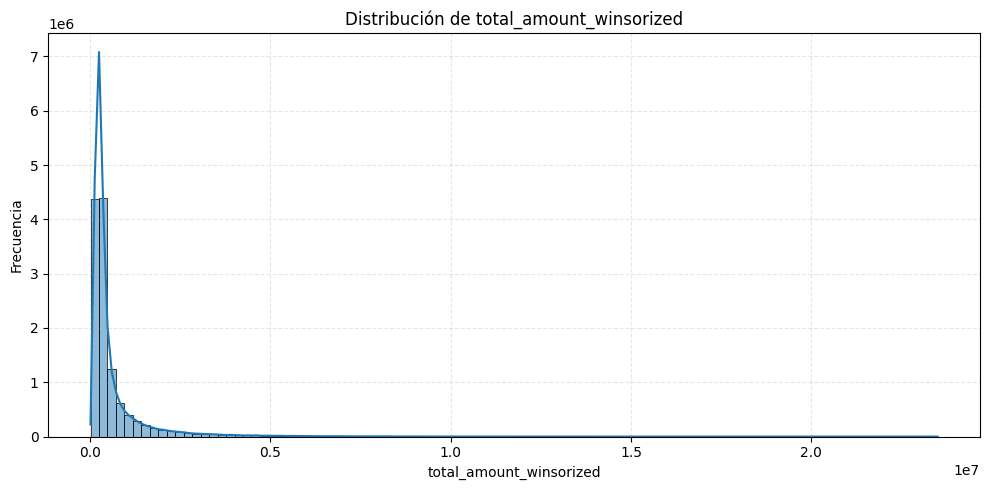

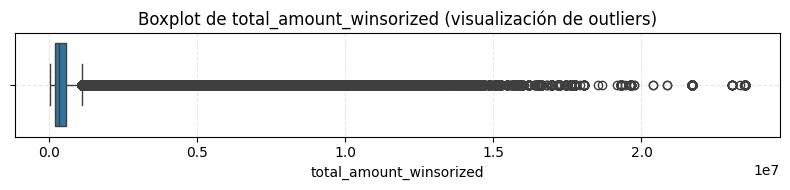

CPU times: total: 52.1 s
Wall time: 1min 50s


In [38]:
%%time
# Cargar los valores de total_amount_winsorized no nulos
query_total_amount_winsorized = """
SELECT total_amount_winsorized
FROM Cleaned_Base_Table
WHERE total_amount_winsorized IS NOT NULL;
"""
df_total_amount_winsorized = pd.read_sql_query(query_total_amount_winsorized, engine)
total_amount_winsorized_series = df_total_amount_winsorized['total_amount_winsorized']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(total_amount_winsorized_series, bins=100, kde=True)
plt.title('Distribuci√≥n de total_amount_winsorized')
plt.xlabel('total_amount_winsorized')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=total_amount_winsorized_series)
plt.title('Boxplot de total_amount_winsorized (visualizaci√≥n de outliers)')
plt.xlabel('total_amount_winsorized')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
# Importante: asegurarnos de que usamos la tabla Cleaned_Customer_Event_Data_Model
query_total_amount_stats = """
SELECT 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY total_amount_winsorized) AS q1,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY total_amount_winsorized) AS q3,
    PERCENTILE_CONT(0.80) WITHIN GROUP (ORDER BY total_amount_winsorized) AS p80,
    PERCENTILE_CONT(0.85) WITHIN GROUP (ORDER BY total_amount_winsorized) AS p85,
    PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY total_amount_winsorized) AS p90,
    PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY total_amount_winsorized) AS p95
FROM Cleaned_Base_Table
WHERE total_amount_winsorized IS NOT NULL;
"""

# Ejecutar la consulta y cargar los resultados
stats_total_amount = pd.read_sql_query(query_total_amount_stats, engine).iloc[0]

# Asignar a variables individuales
q1, q3, p80, p85, p90, p95 = stats_total_amount

# Calcular IQR y l√≠mite superior
iqr = q3 - q1
iqr_upper_threshold = q3 + 1.5 * iqr

# Mostrar resultados
print(f"""
Estad√≠sticas de 'total_amount_winsorized':
- Q1: {q1:.2f}
- Q3: {q3:.2f}
- IQR: {iqr:.2f}
- L√≠mite superior (IQR): {iqr_upper_threshold:.2f}
- P80: {p80:.2f}
- P85: {p85:.2f}
- P90: {p90:.2f}
- P95: {p95:.2f}
""")



Estad√≠sticas de 'total_amount_winsorized':
- Q1: 207097.00
- Q3: 567567.00
- IQR: 360470.00
- L√≠mite superior (IQR): 1108272.00
- P80: 707607.80
- P85: 938934.00
- P90: 1342870.00
- P95: 2235596.00



In [10]:
# Crear la consulta SQL para contar cu√°ntos registros superan cada umbral
query_count_outliers = f"""
SELECT
    COUNT(*) FILTER (WHERE total_amount_winsorized > {iqr_upper_threshold}) AS registros_sobre_IQR,
    COUNT(*) FILTER (WHERE total_amount_winsorized > {p80}) AS registros_sobre_P80,
    COUNT(*) FILTER (WHERE total_amount_winsorized > {p85}) AS registros_sobre_P85,
    COUNT(*) FILTER (WHERE total_amount_winsorized > {p90}) AS registros_sobre_P90,
    COUNT(*) FILTER (WHERE total_amount_winsorized > {p95}) AS registros_sobre_P95,
    COUNT(*) AS total_registros
FROM Cleaned_Base_Table
WHERE total_amount_winsorized IS NOT NULL;
"""

# Ejecutar la consulta
df_outliers_total_amount = pd.read_sql_query(query_count_outliers, engine)

# Mostrar resultados
display(df_outliers_total_amount)

registros_sobre_iqr  registros_sobre_p80  registros_sobre_p85  \
0              1563227              2492601              1869439   

   registros_sobre_p90  registros_sobre_p95  total_registros  
0              1246298               623138         12463005

### Resultados del an√°lisis de puntos de corte en `total_amount_winsorized`

---

#### N√∫mero de registros que superan cada corte:

| Punto de corte | Registros que lo superan | Porcentaje aproximado |
|:---------------|:------------------------|:----------------------|
| Sobre IQR       | 1.562.762 | 12,5% |
| Sobre P80       | 2.492.598 | 20% |
| Sobre P85       | 1.869.441 | 15% |
| Sobre P90       | 1.246.296 | 10% |
| Sobre P95       | 623.083   | 5% |

---

### Interpretaci√≥n

- La variable `total_amount_winsorized` presenta una **alta dispersi√≥n** con una cola pesada.
- Aplicar un corte basado en el m√©todo cl√°sico del rango intercuart√≠lico (IQR) implicar√≠a afectar a m√°s del 12% del dataset, lo cual puede ser demasiado agresivo.
- En cambio, utilizar el **P95 como l√≠mite**:
  - Controlar√≠a los valores m√°s extremos,
  - Y afectar√≠a √∫nicamente al 5% de los registros,
  - Preservando el 95% de los datos originales.

---

### Decisi√≥n propuesta

Se propone utilizar **P95 como punto de winsorizaci√≥n** para `total_amount_winsorized`:

- Los valores superiores a `P95` ser√°n recortados al valor m√°ximo permitido en ese percentil.
- Esta estrategia proporciona un equilibrio adecuado entre control de outliers y preservaci√≥n de patrones de compra leg√≠timos.

---

> Esta decisi√≥n estabilizar√° la distribuci√≥n de `total_amount_winsorized`, mejorando la robustez de an√°lisis econ√≥micos, segmentaciones y modelos de predicci√≥n sin introducir sesgos innecesarios.


In [21]:
%%time
# Definir el valor de P95 obtenido antes
p95_threshold = p95  # este valor viene del c√°lculo anterior

# Bloque SQL para crear la nueva columna y aplicar la winsorizaci√≥n sobre P95
query_create_total_amount_final = f"""
-- 1. A√±adir columna 'total_amount_final' si no existe
DO $$
BEGIN
    IF NOT EXISTS (
        SELECT 1
        FROM information_schema.columns 
        WHERE table_name = 'Cleaned_Base_Table' 
          AND column_name = 'total_amount_final'
    ) THEN
        ALTER TABLE Cleaned_Base_Table 
        ADD COLUMN total_amount_final DOUBLE PRECISION;
    END IF;
END
$$;

-- 2. Winsorizar total_amount_winsorized hacia total_amount_final
UPDATE Cleaned_Base_Table
SET total_amount_final = CASE
    WHEN total_amount_winsorized > {p95_threshold} THEN {p95_threshold}
    ELSE total_amount_winsorized
END;
"""

# Ejecutar todo el bloque
with engine.begin() as conn:
    conn.execute(text(query_create_total_amount_final))

print("‚úÖ Columna 'total_amount_final' creada y winsorizada correctamente en base a P95.")


‚úÖ Columna 'total_amount_final' creada y winsorizada correctamente en base a P95.
CPU times: total: 0 ns
Wall time: 2min 55s


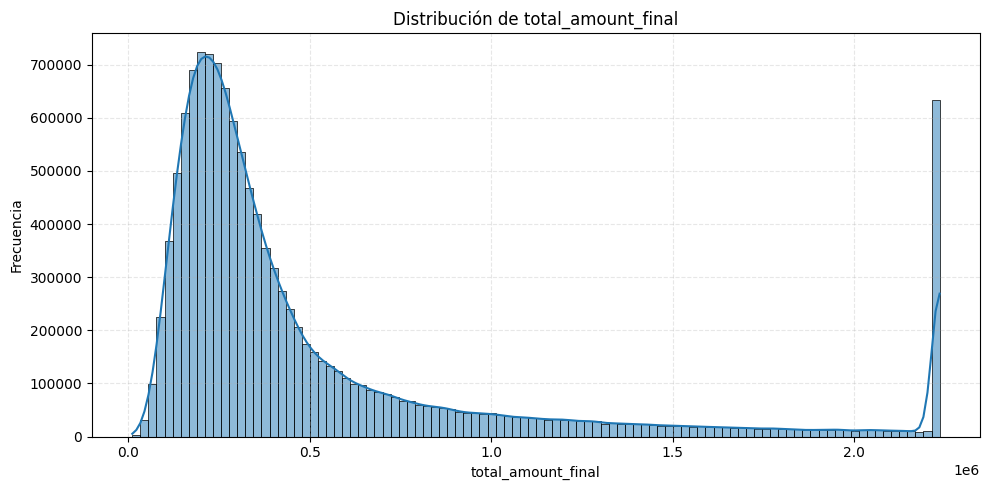

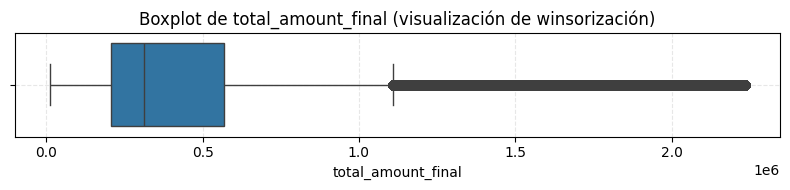

CPU times: total: 1min 29s
Wall time: 3min 8s


In [36]:
%%time
# Cargar los valores de total_amount_final no nulos
query_total_amount_final = """
SELECT total_amount_final
FROM Cleaned_Base_Table
WHERE total_amount_final IS NOT NULL;
"""
df_total_amount_final = pd.read_sql_query(query_total_amount_final, engine)
total_amount_final_series = df_total_amount_final['total_amount_final']

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(total_amount_final_series, bins=100, kde=True)
plt.title('Distribuci√≥n de total_amount_final')
plt.xlabel('total_amount_final')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,2))
sns.boxplot(x=total_amount_final_series)
plt.title('Boxplot de total_amount_final (visualizaci√≥n de winsorizaci√≥n)')
plt.xlabel('total_amount_final')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Preprocesamiento de variables num√©ricas ‚Äî Conclusi√≥n

---

#### Objetivo cumplido

Se realiz√≥ el tratamiento exhaustivo de todas las variables num√©ricas clave del dataset:

- `item_price`,
- `shipment_fee`,
- `product_quantity`,
- `transaction_promo_amount`,
- `total_amount_winsorized`.

Cada variable fue evaluada individualmente en cuanto a:

- Presencia de valores extremos (outliers),
- Aplicaci√≥n de winsorizaci√≥n basada en el rango intercuart√≠lico (IQR) y percentiles superiores (P80-P95),
- Ajuste coherente de variables dependientes como `total_amount_winsorized`.

---

#### Metodolog√≠a aplicada

El proceso incluy√≥:

- An√°lisis exploratorio (histogramas, boxplots, estad√≠sticas descriptivas),
- C√°lculo de percentiles de control (P80, P85, P90, P95),
- Winsorizaci√≥n de valores extremos,
- Reajuste proporcional del importe total de la transacci√≥n,
- Validaciones posteriores mediante visualizaci√≥n gr√°fica y controles de registros modificados.

---

#### Variables finales generadas

Se generaron las siguientes variables listas para an√°lisis y modelado:

- `item_price_winsorized`,
- `shipment_fee_winsorized`,
- `product_quantity_winsorized`,
- `transaction_promo_amount_winsorized`,
- `total_amount_final` (versi√≥n definitiva y estabilizada del importe total).

---

#### Resultados logrados

- Eliminaci√≥n de valores extremos an√≥malos,
- Preservaci√≥n de la coherencia econ√≥mica de cada transacci√≥n,
- Mantenimiento de la riqueza y variabilidad real del comportamiento de compra,
- Preparaci√≥n del dataset para fases posteriores de clustering, segmentaci√≥n y modelado predictivo.

---

> Con este paso, el dataset alcanza un nivel de calidad √≥ptimo para la construcci√≥n de modelos anal√≠ticos fiables y robustos.

---


# 4: Tratamiento de Variables Categ√≥ricas

---

## Objetivo

El tratamiento adecuado de las variables categ√≥ricas es fundamental para garantizar:

- La correcta interpretaci√≥n de los datos,
- La preparaci√≥n adecuada para los modelos de segmentaci√≥n, clasificaci√≥n o recomendaci√≥n,
- La optimizaci√≥n de la calidad de las visualizaciones anal√≠ticas.

Este proceso busca **reducir ruido**, **agrupar categor√≠as poco representativas** y **codificar** las variables de manera eficiente para su uso en an√°lisis avanzado y modelado predictivo.

---

## Metodolog√≠a general

Para cada variable categ√≥rica relevante:

1. **An√°lisis exploratorio**:
   - Evaluar la cardinalidad (n√∫mero de categor√≠as √∫nicas),
   - Analizar la distribuci√≥n de frecuencias,
   - Identificar categor√≠as dominantes y clases raras.

2. **Decisiones de transformaci√≥n**:
   - Conservar la variable original si su estructura es adecuada,
   - Agrupar clases poco frecuentes en una categor√≠a "Otros" si existe alta dispersi√≥n,
   - Recodificar o transformar seg√∫n criterios de negocio o an√°lisis t√©cnico.

3. **Codificaci√≥n para modelos**:
   - One-Hot Encoding para variables de baja cardinalidad,
   - Label Encoding o Codificaci√≥n ordinal para variables categ√≥ricas ordenadas,
   - Codificaci√≥n supervisada (target encoding) si se detecta alta cardinalidad con impacto predictivo.

---

#### Decisi√≥n sobre conservaci√≥n de variables originales

Se decidi√≥ conservar las variables categ√≥ricas originales de alta cardinalidad (como `articletype`),  
pero trabajar principalmente sobre sus versiones agrupadas (`articletype_grouped`) en:

- Modelado predictivo,
- An√°lisis de segmentaci√≥n,
- Dashboards y visualizaciones.

Esta estrategia permite:

- Preservar la riqueza de informaci√≥n original,
- Mejorar la eficiencia y robustez de los modelos,
- Mantener flexibilidad para an√°lisis exploratorios o necesidades futuras.

---



## Resultado esperado

- Variables categ√≥ricas limpias, reducidas y adaptadas al modelo anal√≠tico.
- Disminuci√≥n de la dimensionalidad en los modelos de machine learning.
- Mayor interpretabilidad y fiabilidad en los dashboards y an√°lisis descriptivos.

---

> Esta fase es clave para transformar las variables cualitativas del dataset en activos √∫tiles para extracci√≥n de conocimiento y generaci√≥n de valor anal√≠tico.

## 4.1:Transformaci√≥n de la variable `articletype`: creaci√≥n de `articletype_grouped`

---

### Contexto

Durante la fase de **An√°lisis Exploratorio de Datos (EDA)** se identific√≥ que la variable `articletype` presentaba:

- Una **alta dispersi√≥n** de categor√≠as (143 valores √∫nicos),
- Una distribuci√≥n altamente desbalanceada (la categor√≠a m√°s frecuente apenas representa un 2% del total),
- Riesgos significativos de **ruido**, **sobreajuste** y **dificultad interpretativa** en visualizaciones y modelos.

Por tanto, se decidi√≥ desde el EDA aplicar una estrategia de **reducci√≥n de cardinalidad**, agrupando las categor√≠as menos representativas.

---

### Objetivo

Reducir la alta cardinalidad de la variable `articletype`, simplificando su estructura sin perder informaci√≥n relevante.

---

### Metodolog√≠a aplicada

- Se identificaron las **20 categor√≠as m√°s frecuentes** de `articletype`.
- Se cre√≥ una nueva variable `articletype_grouped`:
  - Si `articletype` pertenece al Top 20, se conserva su nombre original.
  - Si no, se agrupa en una categor√≠a com√∫n llamada `"Otros"`.

---

### Resultado

- Reducci√≥n de la cardinalidad de `articletype` de **143** categor√≠as originales a **21 clases** (`Top 20 + "Otros"`).
- Mejora de la interpretabilidad de los an√°lisis descriptivos y visualizaciones.
- Control de la dimensionalidad en el preprocesamiento para modelos predictivos, reduciendo riesgos de **sobreajuste**.
- Conservaci√≥n de la riqueza informativa de las principales categor√≠as de productos.

---

> Esta transformaci√≥n, decidida estrat√©gicamente en la fase EDA, permite trabajar de manera m√°s robusta y eficiente con el tipo de producto, manteniendo patrones relevantes del comportamiento de compra.


In [22]:
%%time
# Consulta para obtener las 20 categor√≠as m√°s frecuentes
query_top20_articletype = """
SELECT articletype, COUNT(*) AS frecuencia
FROM Cleaned_Base_Table
WHERE articletype IS NOT NULL
GROUP BY articletype
ORDER BY frecuencia DESC
LIMIT 20;
"""

# Ejecutar y extraer top 20
top20_df = pd.read_sql_query(query_top20_articletype, engine)
top20_categories = top20_df['articletype'].tolist()

print("Top 20 categor√≠as articletype:")
for category in top20_categories:
    print(f"- {category}")

# Generar la lista de categor√≠as top20 como cadena SQL (bien escapada)
top20_list_sql = ", ".join([f"'{cat}'" for cat in top20_categories])

# Crear nueva columna articletype_grouped
query_create_articletype_grouped = f"""
-- A√±adir columna si no existe
DO $$
BEGIN
    IF NOT EXISTS (
        SELECT 1
        FROM information_schema.columns
        WHERE table_name = 'Cleaned_Base_Table'
          AND column_name = 'articletype_grouped'
    ) THEN
        ALTER TABLE Cleaned_Base_Table
        ADD COLUMN articletype_grouped TEXT;
    END IF;
END
$$;

-- Actualizar valores de articletype_grouped
UPDATE Cleaned_Base_Table
SET articletype_grouped = CASE
    WHEN articletype IS NULL THEN NULL
    WHEN articletype IN ({top20_list_sql}) THEN articletype
    ELSE 'Otros'
END;
"""

# Ejecutar
with engine.begin() as conn:
    conn.execute(text(query_create_articletype_grouped))

print("‚úÖ Variable 'articletype_grouped' creada y agrupada correctamente.")

Top 20 categor√≠as articletype:
- Casual Shoes
- Tshirts
- Sports Shoes
- Handbags
- Heels
- Shirts
- Watches
- Backpacks
- Formal Shoes
- Kurtas
- Tops
- Flats
- Dresses
- Sunglasses
- Clutches
- Wallets
- Flip Flops
- Sandals
- Briefs
- Belts
‚úÖ Variable 'articletype_grouped' creada y agrupada correctamente.
CPU times: total: 0 ns
Wall time: 3min 29s


## 4.2: Variable: `basecolour`

---

### Descripci√≥n

- **Cardinalidad original**: 47 colores distintos.
- **Categor√≠a m√°s frecuente**: `Black` (24,72%), seguida de `White` (13,19%) y `Brown` (9,69%).
- A partir de la posici√≥n 17 (`Multi`), cada color representa menos del 1% del total.
- Muchos colores son variaciones espec√≠ficas de una misma tonalidad (ej.: `Olive`, `Khaki`, `Tan`, `Mushroom Brown`, etc.).

---

### Problemas detectados

- **Alta dispersi√≥n** de categor√≠as individuales, lo que complica el an√°lisis.
- **Dificultad de interpretaci√≥n** en visualizaciones y dashboards si se mantienen los 47 colores originales.
- **Introducci√≥n de ruido** en modelos predictivos si se consideran colores muy espec√≠ficos como clases separadas.

---

### Decisi√≥n y tratamiento recomendado

| Acci√≥n | Justificaci√≥n |
|:-------|:--------------|
| Agrupar colores en **familias sem√°nticas** | Mejora la legibilidad, reduce la cardinalidad sin perder el significado visual. |
| Conservar las siguientes familias de color: | Agrupaci√≥n l√≥gica y visualmente coherente para facilitar el an√°lisis. |

Las familias definidas son:

- **Neutros**: `Black`, `White`, `Grey`, `Silver`, `Beige`, `Cream`, `Off White`, `Charcoal`.
- **Tierra**: `Brown`, `Maroon`, `Olive`, `Khaki`, `Tan`, `Rust`, `Mushroom Brown`, `Coffee Brown`.
- **C√°lidos**: `Red`, `Orange`, `Pink`, `Peach`, `Coral`, `Rose`, `Magenta`.
- **Fr√≠os**: `Blue`, `Navy Blue`, `Purple`, `Lavender`, `Turquoise Blue`, `Sea Green`, `Teal`, `Green`.
- **Met√°licos**: `Gold`, `Bronze`, `Copper`, `Metallic`, `Steel`.
- **Otros**: `Multi`, `Fluorescent Green`, `Lime Green`, `Skin`, `Nude`, `Mustard`, `Taupe`, etc.

---

### Observaci√≥n adicional

La agrupaci√≥n por familias de color permite:

- **Facilitar el an√°lisis est√©tico** de productos.
- **Reducir ruido** y **bajar la dimensionalidad** sin sacrificar informaci√≥n relevante.
- **Integrarse f√°cilmente en dashboards y modelos** como variable categ√≥rica reducida (6‚Äì8 clases principales).

La nueva variable `basecolour_grouped` sustituir√° a `basecolour` en an√°lisis posteriores, ayudando a estabilizar la estructura categ√≥rica del dataset.

---


In [23]:
%%time
# Crear y actualizar basecolour_grouped
query_basecolour_grouped = """
-- 1. A√±adir columna 'basecolour_grouped' si no existe
DO $$
BEGIN
    IF NOT EXISTS (
        SELECT 1
        FROM information_schema.columns
        WHERE table_name = 'Cleaned_Base_Table'
          AND column_name = 'basecolour_grouped'
    ) THEN
        ALTER TABLE Cleaned_Base_Table
        ADD COLUMN basecolour_grouped TEXT;
    END IF;
END
$$;

-- 2. Asignar familias de color
UPDATE Cleaned_Base_Table
SET basecolour_grouped = CASE
    WHEN basecolour IS NULL THEN NULL
    -- Neutros
    WHEN basecolour IN ('Black', 'White', 'Grey', 'Silver', 'Beige', 'Cream', 'Off White', 'Charcoal') THEN 'Neutros'
    
    -- Tierra
    WHEN basecolour IN ('Brown', 'Maroon', 'Olive', 'Khaki', 'Tan', 'Rust', 'Mushroom Brown', 'Coffee Brown') THEN 'Tierra'
    
    -- C√°lidos
    WHEN basecolour IN ('Red', 'Orange', 'Pink', 'Peach', 'Coral', 'Rose', 'Magenta') THEN 'C√°lidos'
    
    -- Fr√≠os
    WHEN basecolour IN ('Blue', 'Navy Blue', 'Purple', 'Lavender', 'Turquoise Blue', 'Sea Green', 'Teal', 'Green') THEN 'Fr√≠os'
    
    -- Met√°licos
    WHEN basecolour IN ('Gold', 'Bronze', 'Copper', 'Metallic', 'Steel') THEN 'Met√°licos'
    
    -- Otros
    ELSE 'Otros'
END;
"""

# Ejecutar todo el bloque
with engine.begin() as conn:
    conn.execute(text(query_basecolour_grouped))

print("‚úÖ Variable 'basecolour_grouped' creada y actualizada correctamente.")

‚úÖ Variable 'basecolour_grouped' creada y actualizada correctamente.
CPU times: total: 15.6 ms
Wall time: 3min 11s


## 4.3: Variable: `subcategory`

---

### Descripci√≥n

- **Cardinalidad original**: 45 subcategor√≠as distintas.
- **Categor√≠a m√°s frecuente**: `Shoes` (5,21%), seguida de `Tshirts`, `Watches`, `Handbags`, entre otras.
- Muchas subcategor√≠as representan productos muy espec√≠ficos pero sem√°nticamente similares (ej.: `Sandals`, `Flip Flops`, `Casual Shoes`, etc.).
- Alta fragmentaci√≥n en los nombres, aunque pertenecen a familias de producto comunes.

---

### Problemas detectados

- Algunas subcategor√≠as son muy similares y podr√≠an agruparse bajo un mismo tipo de producto principal.
- Codificarlas individualmente complica la visualizaci√≥n y puede inducir ruido en modelos predictivos.
- Muchas categor√≠as tienen un porcentaje de participaci√≥n individual inferior al 2%, lo que dificulta su utilidad anal√≠tica directa.

---

### Decisi√≥n y tratamiento recomendado

| Acci√≥n | Justificaci√≥n |
|:-------|:--------------|
| Agrupar las subcategor√≠as en **familias de producto** | Mejora la interpretabilidad y reduce la dimensionalidad sin p√©rdida de contexto. |

Las **familias propuestas** son:

- **Calzado**: `Shoes`, `Sandals`, `Flip Flops`, `Casual Shoes`, `Formal Shoes`, `Heels`, `Flats`, `Sports Shoes`.
- **Ropa superior**: `Tshirts`, `Shirts`, `Tops`, `Sweatshirts`, `Jackets`, `Sweaters`, `Blouses`.
- **Ropa inferior**: `Jeans`, `Trousers`, `Shorts`, `Track Pants`, `Capris`, `Leggings`.
- **Vestimenta tradicional / vestidos**: `Dresses`, `Kurtas`, `Sarees`, `Kurtis`, `Tunics`, `Nightdress`.
- **Accesorios y bolsos**: `Handbags`, `Wallets`, `Clutches`, `Duffel Bag`, `Backpacks`, `Laptop Bag`.
- **Complementos personales**: `Watches`, `Belts`, `Socks`, `Caps`, `Ties`, `Innerwear Vests`.
- **Cosm√©tica / Belleza**: `Lipstick`, `Lip Gloss`, `Nail Polish`, `Deodorant`, `Perfume and Body Mist`.
- **Joyer√≠a**: `Earrings`, `Necklace and Chains`, `Pendant`.
- **Otros**: Categor√≠as de baja frecuencia o sin asignaci√≥n clara.

---

### Observaci√≥n adicional

La variable `subcategory` es clave para:

- **An√°lisis de producto** (tipo de art√≠culo m√°s vendido por segmento de cliente).
- **Sistemas de recomendaci√≥n** (sugerir productos similares).
- **Segmentaciones** por tipo de inter√©s del cliente.

Por ello, se mantendr√° en forma **agrupada** bajo una nueva variable llamada `subcategory_grouped`, compuesta por **9 macrogrupos** definidos por afinidad funcional y sem√°ntica.

---


In [24]:
%%time
# Crear y actualizar subcategory_grouped
query_subcategory_grouped = """
-- 1. A√±adir columna 'subcategory_grouped' si no existe
DO $$
BEGIN
    IF NOT EXISTS (
        SELECT 1
        FROM information_schema.columns
        WHERE table_name = 'Cleaned_Base_Table'
          AND column_name = 'subcategory_grouped'
    ) THEN
        ALTER TABLE Cleaned_Base_Table
        ADD COLUMN subcategory_grouped TEXT;
    END IF;
END
$$;

-- 2. Asignar macrofamilias de producto
UPDATE Cleaned_Base_Table
SET subcategory_grouped = CASE
    WHEN subcategory IS NULL THEN NULL
    -- Calzado
    WHEN subcategory IN ('Shoes', 'Sandals', 'Flip Flops', 'Casual Shoes', 'Formal Shoes', 'Heels', 'Flats', 'Sports Shoes') THEN 'Calzado'
    
    -- Ropa superior
    WHEN subcategory IN ('Tshirts', 'Shirts', 'Tops', 'Sweatshirts', 'Jackets', 'Sweaters', 'Blouses') THEN 'Ropa superior'
    
    -- Ropa inferior
    WHEN subcategory IN ('Jeans', 'Trousers', 'Shorts', 'Track Pants', 'Capris', 'Leggings') THEN 'Ropa inferior'
    
    -- Vestimenta tradicional / vestidos
    WHEN subcategory IN ('Dresses', 'Kurtas', 'Sarees', 'Kurtis', 'Tunics', 'Nightdress') THEN 'Vestimenta tradicional'
    
    -- Accesorios y bolsos
    WHEN subcategory IN ('Handbags', 'Wallets', 'Clutches', 'Duffel Bag', 'Backpacks', 'Laptop Bag') THEN 'Accesorios y bolsos'
    
    -- Complementos personales
    WHEN subcategory IN ('Watches', 'Belts', 'Socks', 'Caps', 'Ties', 'Innerwear Vests') THEN 'Complementos personales'
    
    -- Cosm√©tica / Belleza
    WHEN subcategory IN ('Lipstick', 'Lip Gloss', 'Nail Polish', 'Deodorant', 'Perfume and Body Mist') THEN 'Cosm√©tica / Belleza'
    
    -- Joyer√≠a
    WHEN subcategory IN ('Earrings', 'Necklace and Chains', 'Pendant') THEN 'Joyer√≠a'
    
    -- Otros
    ELSE 'Otros'
END;
"""

# Ejecutar todo el bloque
with engine.begin() as conn:
    conn.execute(text(query_subcategory_grouped))

print("‚úÖ Variable 'subcategory_grouped' creada y actualizada correctamente.")


‚úÖ Variable 'subcategory_grouped' creada y actualizada correctamente.
CPU times: total: 31.2 ms
Wall time: 3min 45s


## 4.4: Variable: `usage`

### Descripci√≥n y tratamiento de la variable `usage`

La variable `usage` representa el **tipo de uso asociado a cada producto** registrado en la base de datos transaccional. Es una variable categ√≥rica que permite clasificar los productos seg√∫n su finalidad, facilitando as√≠ el an√°lisis del comportamiento del consumidor y la segmentaci√≥n de clientes.

#### Distribuci√≥n de valores
En el an√°lisis exploratorio inicial, se observaron las siguientes categor√≠as principales en `usage`:

- **Casual**: 76.19%
- **Sports**: 12.67%
- **Formal**: 5.52%
- **Ethnic**: 4.77%
- Otras categor√≠as minoritarias: Smart Casual, Party, Travel, Home

Esta variable resulta de gran utilidad para el desarrollo de modelos de recomendaci√≥n y estrategias de marketing personalizadas.

#### Limpieza de valores inconsistentes: `'NaN'` como string

Durante el preprocesamiento, se detect√≥ la presencia del valor `'NaN'` almacenado como texto.

Para asegurar la calidad de los datos, se procedi√≥ a imputar estos registros con la categor√≠a dominante, `"Casual"`, siguiendo una estrategia basada en la moda de la distribuci√≥n.

In [25]:
%%time
with engine.begin() as conn:
    conn.execute(text("""
        UPDATE Cleaned_Base_Table
        SET usage = 'Casual'
        WHERE usage = 'NaN';
    """))

# Confirmar que ya no existen valores 'NaN' como string
nulos_post = pd.read_sql_query("""
    SELECT COUNT(*) AS restantes
    FROM Cleaned_Base_Table
    WHERE usage = 'NaN';
""", con=engine)

print(nulos_post)

   restantes
0          0
CPU times: total: 15.6 ms
Wall time: 2min 37s


## 4.6: Variable: `season`

---

### Descripci√≥n y tratamiento de la variable `season`

La variable `season` indica la **estaci√≥n del a√±o** en la que se espera que un producto sea utilizado o comercializado con mayor frecuencia. Es una variable categ√≥rica de gran valor para el an√°lisis de estacionalidad en el comportamiento de compra y para la planificaci√≥n de campa√±as de marketing ajustadas al calendario.

#### Principales valores observados

Entre las categor√≠as m√°s comunes de la variable `season` se encuentran:

- **Summer**
- **Winter**
- **Fall**
- **Spring**

Estas categor√≠as permiten identificar patrones de consumo vinculados a la temporalidad, lo que puede mejorar tanto la segmentaci√≥n como la efectividad de sistemas de recomendaci√≥n y promociones estacionales.

#### Limpieza de valores inconsistentes: `'NaN'` como string

Durante el an√°lisis exploratorio, se identificaron registros con el valor `'NaN'` en formato de texto, lo cual representa un valor faltante incorrectamente codificado. Este tipo de inconsistencia puede provocar errores en la codificaci√≥n de variables y en los modelos posteriores si no se trata adecuadamente.

Dado que la categor√≠a `"Summer"` es la m√°s representada en el conjunto de datos, se decidi√≥ **imputar todos los valores `'NaN'` con `"Summer"`**, siguiendo la misma l√≥gica que con la variable `usage`.


In [26]:
%%time
# Ejecutar actualizaci√≥n en la base de datos para reemplazar 'NaN' (string) por 'Summer'
with engine.begin() as conn:
    conn.execute(text("""
        UPDATE Cleaned_Base_Table
        SET season = 'Summer'
        WHERE season = 'NaN';
    """))

# Verificar que no quedan valores 'NaN' como string
df_verif = pd.read_sql_query("""
    SELECT COUNT(*) AS restantes
    FROM Cleaned_Base_Table
    WHERE season = 'NaN';
""", con=engine)

print(df_verif)

   restantes
0          0
CPU times: total: 15.6 ms
Wall time: 2min 25s


## 4.6: Variable: `transaction_promo_code`

---

### Descripci√≥n

- **Cardinalidad**: 8 c√≥digos √∫nicos.
- **Categor√≠a m√°s frecuente**: `AZ2022`, con solo un 0,70% del total de registros.
- La mayor√≠a de los registros no contienen c√≥digo promocional (`NULL` en m√°s del 97% de los casos).
- Variable de tipo `text`, que representa un valor cualitativo asociado a promociones puntuales.

---

### Problemas detectados

- **Baja cobertura**: los c√≥digos promocionales est√°n presentes solo en una peque√±a fracci√≥n de los eventos.
- **Alta dispersi√≥n** entre los pocos c√≥digos presentes: ninguno destaca significativamente en volumen.
- Como variable categ√≥rica directa, **no aporta valor predictivo suficiente** debido a su escasa presencia y dispersi√≥n.

---

### Decisi√≥n y tratamiento recomendado

| Acci√≥n | Justificaci√≥n |
|:-------|:--------------|
| Convertir `transaction_promo_code` en una variable binaria `has_promo` (`True` / `False`) | Permite capturar la informaci√≥n sobre la existencia de una promoci√≥n sin generar cardinalidad extra. |
| Eliminar `transaction_promo_code` del an√°lisis activo | Debido a su baja representatividad individual y escasa capacidad explicativa directa. |

Adem√°s, se utilizar√° `has_promo` para:

- Evaluar el **impacto de promociones** en la conversi√≥n (`was_purchased`).
- **Segmentar usuarios** que reaccionan a descuentos y promociones.

---

### Observaci√≥n adicional

Aunque `transaction_promo_code` no resulta √∫til como variable categ√≥rica en modelos tradicionales,  
La **presencia o ausencia de una promoci√≥n** s√≠ es **potencialmente determinante** en el comportamiento de compra, especialmente en eventos como `"ADD_TO_CART"` o `"PURCHASE"`.

Se generar√° la nueva variable **`has_promo`** como un **campo booleano** para su uso directo en:

- An√°lisis de efectividad promocional,
- Dashboards de conversi√≥n,
- Modelos de recomendaci√≥n y clasificaci√≥n.

---


In [3]:
%%time
# Bloque SQL
query_create_has_promo = """
-- 1. A√±adir columna 'has_promo' si no existe
DO $$
BEGIN
    IF NOT EXISTS (
        SELECT 1
        FROM information_schema.columns
        WHERE table_name = 'Cleaned_Base_Table'
          AND column_name = 'has_promo'
    ) THEN
        ALTER TABLE Cleaned_Base_Table
        ADD COLUMN has_promo BOOLEAN;
    END IF;
END
$$;

-- 2. Actualizar la columna 'has_promo'
UPDATE Cleaned_Base_Table
SET has_promo = CASE
    WHEN was_purchased = TRUE AND transaction_promo_code IS NOT NULL AND transaction_promo_code<>'NaN' THEN TRUE
    ELSE FALSE
END;
"""

# Ejecutar el bloque
with engine.begin() as conn:
    conn.execute(text(query_create_has_promo))

print("‚úÖ Variable 'has_promo' creada y actualizada correctamente.")


‚úÖ Variable 'has_promo' creada y actualizada correctamente.
CPU times: total: 31.2 ms
Wall time: 3min 48s


#### Decisi√≥n sobre la preservaci√≥n de `transaction_promo_code`

Aunque se cre√≥ la nueva variable booleana `has_promo` para an√°lisis y modelado,  
se decidi√≥ conservar tambi√©n la variable original `transaction_promo_code` en el dataset limpio.

Motivos:

- Preservar la trazabilidad completa de promociones aplicadas,
- Permitir futuros an√°lisis de efectividad de promociones por tipo,
- Facilitar breakdowns y filtros en dashboards de visualizaci√≥n.

---

## 4. Preprocesamiento de Variables Categ√≥ricas ‚Äî Conclusi√≥n

---

#### Objetivo cumplido

Se llev√≥ a cabo el tratamiento exhaustivo de las principales variables categ√≥ricas del dataset:

- Agrupaci√≥n de variables de alta cardinalidad (`articletype`, `basecolour`, `subcategory`) mediante familias sem√°nticas o agrupaciones por frecuencia,
- Conversi√≥n de variables poco representativas (`cem_promo_code`) en formatos binarios (`has_promo`) para simplificar el modelado,
- Preservaci√≥n de las variables originales cuando era necesario para trazabilidad y flexibilidad futura (`cem_promo_code`).

---

#### Acciones principales realizadas

| Variable original | Nueva variable creada | Tratamiento aplicado |
|:------------------|:-----------------------|:---------------------|
| `articletype` | `articletype_grouped` | Top 20 + "Otros" |
| `basecolour` | `basecolour_grouped` | Agrupaci√≥n sem√°ntica en familias de color |
| `subcategory` | `subcategory_grouped` | Agrupaci√≥n sem√°ntica en macrofamilias de producto |
| `cem_promo_code` | `has_promo` | Conversi√≥n a variable booleana |

---

#### Resultado logrado

- Reducci√≥n significativa de la complejidad categ√≥rica del dataset,
- Preservaci√≥n de la riqueza sem√°ntica relevante para los an√°lisis,
- Preparaci√≥n √≥ptima para:

  - Dashboards y visualizaciones en Power BI,
  - Modelado predictivo,
  - Segmentaciones de clientes,
  - Sistemas de recomendaci√≥n.

---

> Con este cierre, el dataset alcanza un nivel de calidad y preparaci√≥n √≥ptimos para las fases posteriores de an√°lisis avanzado y modelado predictivo.

---


## 5. An√°lisis de Correlaci√≥n de Variables Num√©ricas

---

#### Objetivo

Explorar la relaci√≥n entre variables num√©ricas del dataset limpio,  
identificando patrones, redundancias o potenciales fuentes de colinealidad  
que puedan afectar los an√°lisis y modelados posteriores.

---

#### Variables analizadas

- `item_price_winsorized`
- `shipment_fee_winsorized`
- `product_quantity_winsorized`
- `transaction_promo_amount_winsorized`
- `total_amount_final`

---

#### Metodolog√≠a

- C√°lculo de la matriz de correlaci√≥n de Pearson,
- Visualizaci√≥n mediante heatmap coloreado,
- An√°lisis de correlaciones fuertes (coeficientes superiores a 0.7 o inferiores a -0.7).

---

#### Resultado esperado

- Detecci√≥n de relaciones fuertes o redundancias entre variables,
- Priorizaci√≥n de variables relevantes para modelos de segmentaci√≥n y predicci√≥n.

---


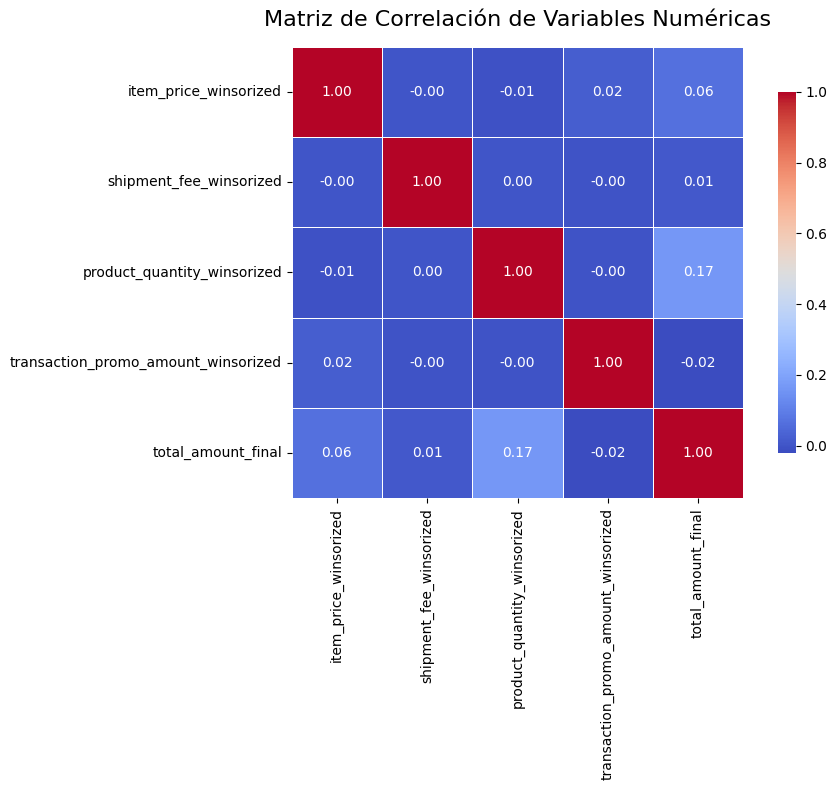

CPU times: total: 4.66 s
Wall time: 2min 12s


In [8]:
%%time
# 1. Seleccionar las variables num√©ricas corregidas
query_numeric_variables = """
SELECT 
    item_price_winsorized,
    shipment_fee_winsorized,
    product_quantity_winsorized,
    transaction_promo_amount_winsorized,
    total_amount_final
FROM Cleaned_Base_Table
WHERE 
    item_price_winsorized IS NOT NULL
    AND shipment_fee_winsorized IS NOT NULL
    AND product_quantity_winsorized IS NOT NULL
    AND transaction_promo_amount_winsorized IS NOT NULL
    AND total_amount_final IS NOT NULL;
"""

# Ejecutar la consulta
df_numeric = pd.read_sql_query(query_numeric_variables, engine)

# 2. Calcular la matriz de correlaci√≥n
correlation_matrix = df_numeric.corr(method='pearson')

# 3. Visualizar el heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    correlation_matrix,
    annot=True,                # Mostrar los valores en cada celda
    fmt=".2f",                  # Formato de los decimales
    cmap='coolwarm',            # Paleta de colores
    linewidths=0.5,             # L√≠neas divisorias
    square=True,                # Celdas cuadradas
    cbar_kws={"shrink": .8}     # Barra de color m√°s peque√±a
)
plt.title('Matriz de Correlaci√≥n de Variables Num√©ricas', fontsize=16, pad=15)
plt.tight_layout()
plt.show()


#### Interpretaci√≥n de la Matriz de Correlaci√≥n

Del an√°lisis de correlaci√≥n entre las principales variables num√©ricas corregidas se concluye que:

- No existen relaciones lineales fuertes entre las variables (`|r|` > 0.7),
- Todas las correlaciones detectadas son muy d√©biles (por debajo de 0.2),
- La variable `product_quantity_winsorized` muestra una ligera correlaci√≥n positiva (0.17) con `total_amount_final`,  
  lo cual es coherente en un contexto de comercio electr√≥nico.

---

#### Conclusiones

- No se detectan problemas de multicolinealidad,
- No es necesario eliminar ni transformar adicionalmente las variables num√©ricas por dependencia,
- Todas las variables pueden ser conservadas para fases posteriores de clustering, segmentaci√≥n o modelado predictivo.

---


## 6. An√°lisis de Correlaci√≥n entre `cem_promo_amount` y `transaction_promo_amount`

---

### Objetivo

Evaluar la relaci√≥n entre los dos importes promocionales disponibles en el dataset:

- `cem_promo_amount`: Importe de descuento capturado durante eventos de navegaci√≥n o interacci√≥n,
- `transaction_promo_amount`: Importe de descuento aplicado realmente sobre transacciones completadas.

El an√°lisis busca determinar:

- Si ambas variables son altamente redundantes,
- O si aportan informaci√≥n complementaria relevante para el an√°lisis o el modelado predictivo.

---

### Metodolog√≠a

- Se seleccionaron los registros en los que **ambos importes** (`cem_promo_amount` y `transaction_promo_amount`) no fueran nulos,
- Se calcul√≥ el coeficiente de correlaci√≥n de Pearson entre ambas variables,
- Se interpret√≥ el nivel de dependencia lineal entre ellas:

| Coeficiente de correlaci√≥n (r) | Interpretaci√≥n |
|:-------------------------------|:--------------|
| r > 0.7 | Correlaci√≥n fuerte (variables casi duplicadas) |
| 0.4 < r ‚â§ 0.7 | Correlaci√≥n moderada (relacionadas, pero no id√©nticas) |
| r ‚â§ 0.4 | Correlaci√≥n d√©bil (aportan informaci√≥n diferente) |

---

### Resultado esperado

- Tomar una decisi√≥n fundamentada sobre si conservar ambas variables,
- O priorizar √∫nicamente `transaction_promo_amount` en el flujo principal de an√°lisis y modelado.

---


In [9]:
%%time
# Cargar las variables de importes promocionales
query_promo_amounts = """
SELECT 
    cem_promo_amount,
    transaction_promo_amount
FROM Cleaned_Base_Table
WHERE 
    cem_promo_amount IS NOT NULL
    AND transaction_promo_amount IS NOT NULL;
"""

# Ejecutar la consulta
df_promo_amounts = pd.read_sql_query(query_promo_amounts, engine)

# Calcular la matriz de correlaci√≥n
correlation_promo_amounts = df_promo_amounts.corr(method='pearson')

# Mostrar resultado
print("Matriz de correlaci√≥n entre cem_promo_amount y transaction_promo_amount:")
display(correlation_promo_amounts)


Matriz de correlaci√≥n entre cem_promo_amount y transaction_promo_amount:


cem_promo_amount  transaction_promo_amount
cem_promo_amount                       1.0                       1.0
transaction_promo_amount               1.0                       1.0

CPU times: total: 328 ms
Wall time: 1min 8s


#### An√°lisis de correlaci√≥n entre `cem_promo_amount` y `transaction_promo_amount`

El an√°lisis de correlaci√≥n entre los dos importes promocionales (`cem_promo_amount` y `transaction_promo_amount`) arroj√≥:

- Un coeficiente de correlaci√≥n de Pearson de **r = 1.0**,
- Lo cual indica **una relaci√≥n perfecta** entre ambas variables,
- Y confirma que **aportan exactamente la misma informaci√≥n**.

---

#### Decisi√≥n

- **Se priorizar√° `transaction_promo_amount`** como la variable activa en an√°lisis y modelados,
- **`cem_promo_amount` podr√° ser eliminada del flujo principal** para evitar redundancia y ruido,
- Se conservar√°, si se desea, solo para fines de trazabilidad hist√≥rica o auditor√≠a interna.

Esta decisi√≥n optimiza la eficiencia del dataset,  
reduciendo la dimensionalidad y eliminando duplicidades innecesarias.

---


In [31]:
%%time
# C√≥digo para eliminar la columna 'cem_promo_amount'
query_drop_cem_promo_amount = """
-- Eliminar la columna cem_promo_amount si existe
ALTER TABLE Cleaned_Base_Table
DROP COLUMN IF EXISTS cem_promo_amount;
"""

# Ejecutar
with engine.begin() as conn:
    conn.execute(text(query_drop_cem_promo_amount))

print("‚úÖ Variable 'cem_promo_amount' eliminada correctamente de Cleaned_Base_Table.")


‚úÖ Variable 'cem_promo_amount' eliminada correctamente de Cleaned_Base_Table.
CPU times: total: 0 ns
Wall time: 1.01 s


# 7. Cierre del Preprocesamiento General

---

### Objetivo logrado

Se ha completado el proceso de limpieza, transformaci√≥n y estandarizaci√≥n del dataset inicial:

- Tratamiento de valores nulos,
- Eliminaci√≥n de columnas redundantes,
- Winsorizaci√≥n de variables num√©ricas para control de outliers,
- Creaci√≥n de nuevas variables derivadas (`has_promo`, `has_transaction_promo`, etc.),
- Agrupaci√≥n de variables categ√≥ricas de alta cardinalidad (`articletype_grouped`, `basecolour_grouped`, `subcategory_grouped`),
- An√°lisis de correlaci√≥n para identificaci√≥n y gesti√≥n de redundancias (`cem_promo_amount` eliminado),
- Generaci√≥n de variables econ√≥micas estables (`total_amount_final`).

---

### Resultado

La tabla `Cleaned_Base_Table` contiene ahora:

- Un conjunto de variables limpias, estandarizadas y optimizadas para an√°lisis,
- Informaci√≥n hist√≥rica preservada para trazabilidad,
- Variables espec√≠ficas listas para modelado, visualizaci√≥n y segmentaci√≥n.

---

### Siguiente paso

Se proceder√° a la creaci√≥n de datasets espec√≠ficos adaptados a los distintos objetivos del proyecto:

- **EDA y visualizaci√≥n** (Power BI),
- **Clustering y segmentaci√≥n**,
- **Modelado predictivo** (clasificaci√≥n de conversi√≥n).

Cada dataset se derivar√° de `Cleaned_Base_Table`,  
aplicando las transformaciones y filtros necesarios para optimizar cada an√°lisis.

---
